# Plots for the Thesis

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import pandas as pd
import glob
import numpy as np 
from os.path import join 
import sys

import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import rc
#rc("font", **{"family": "serif", "serif": ["Palatino"]})
rc("font",**{"family":"sans-serif","sans-serif":["Helvetica"]})
if sys.platform == "darwin":
    rc("text", usetex = True)

from vis import parse_table, pbcc_results, make_dfs, return_asterisks

## Set Parameters for all plots

In [4]:
fig_width = 6.1 # Important to get the plots right in the PDF
posz = 0.4 # Size of the DOT for mean 
lisz = 0.7 # SIze of width of 95% errorbars

c = sns.color_palette()

In [5]:
fss_both = pd.read_csv("fss-both.csv")

In [6]:
dfn = fss_both.query("io != 'X-s'").query("io != 'X-c'").query("io != 'X-y'")
#dfn = dfn.query("model != 'GaussianNB'")
dfn = dfn.query("technique != 'wdcr'").query("technique != 'cvcr'")

dfn = dfn.rename(columns={
    "ba_mean":"ba-mean",
    "ba_pvalue" : "ba-pvalue",
    "ba_ci_low" : "ba-ci-low",
    "ba_ci_high" : "ba-ci-high"
})

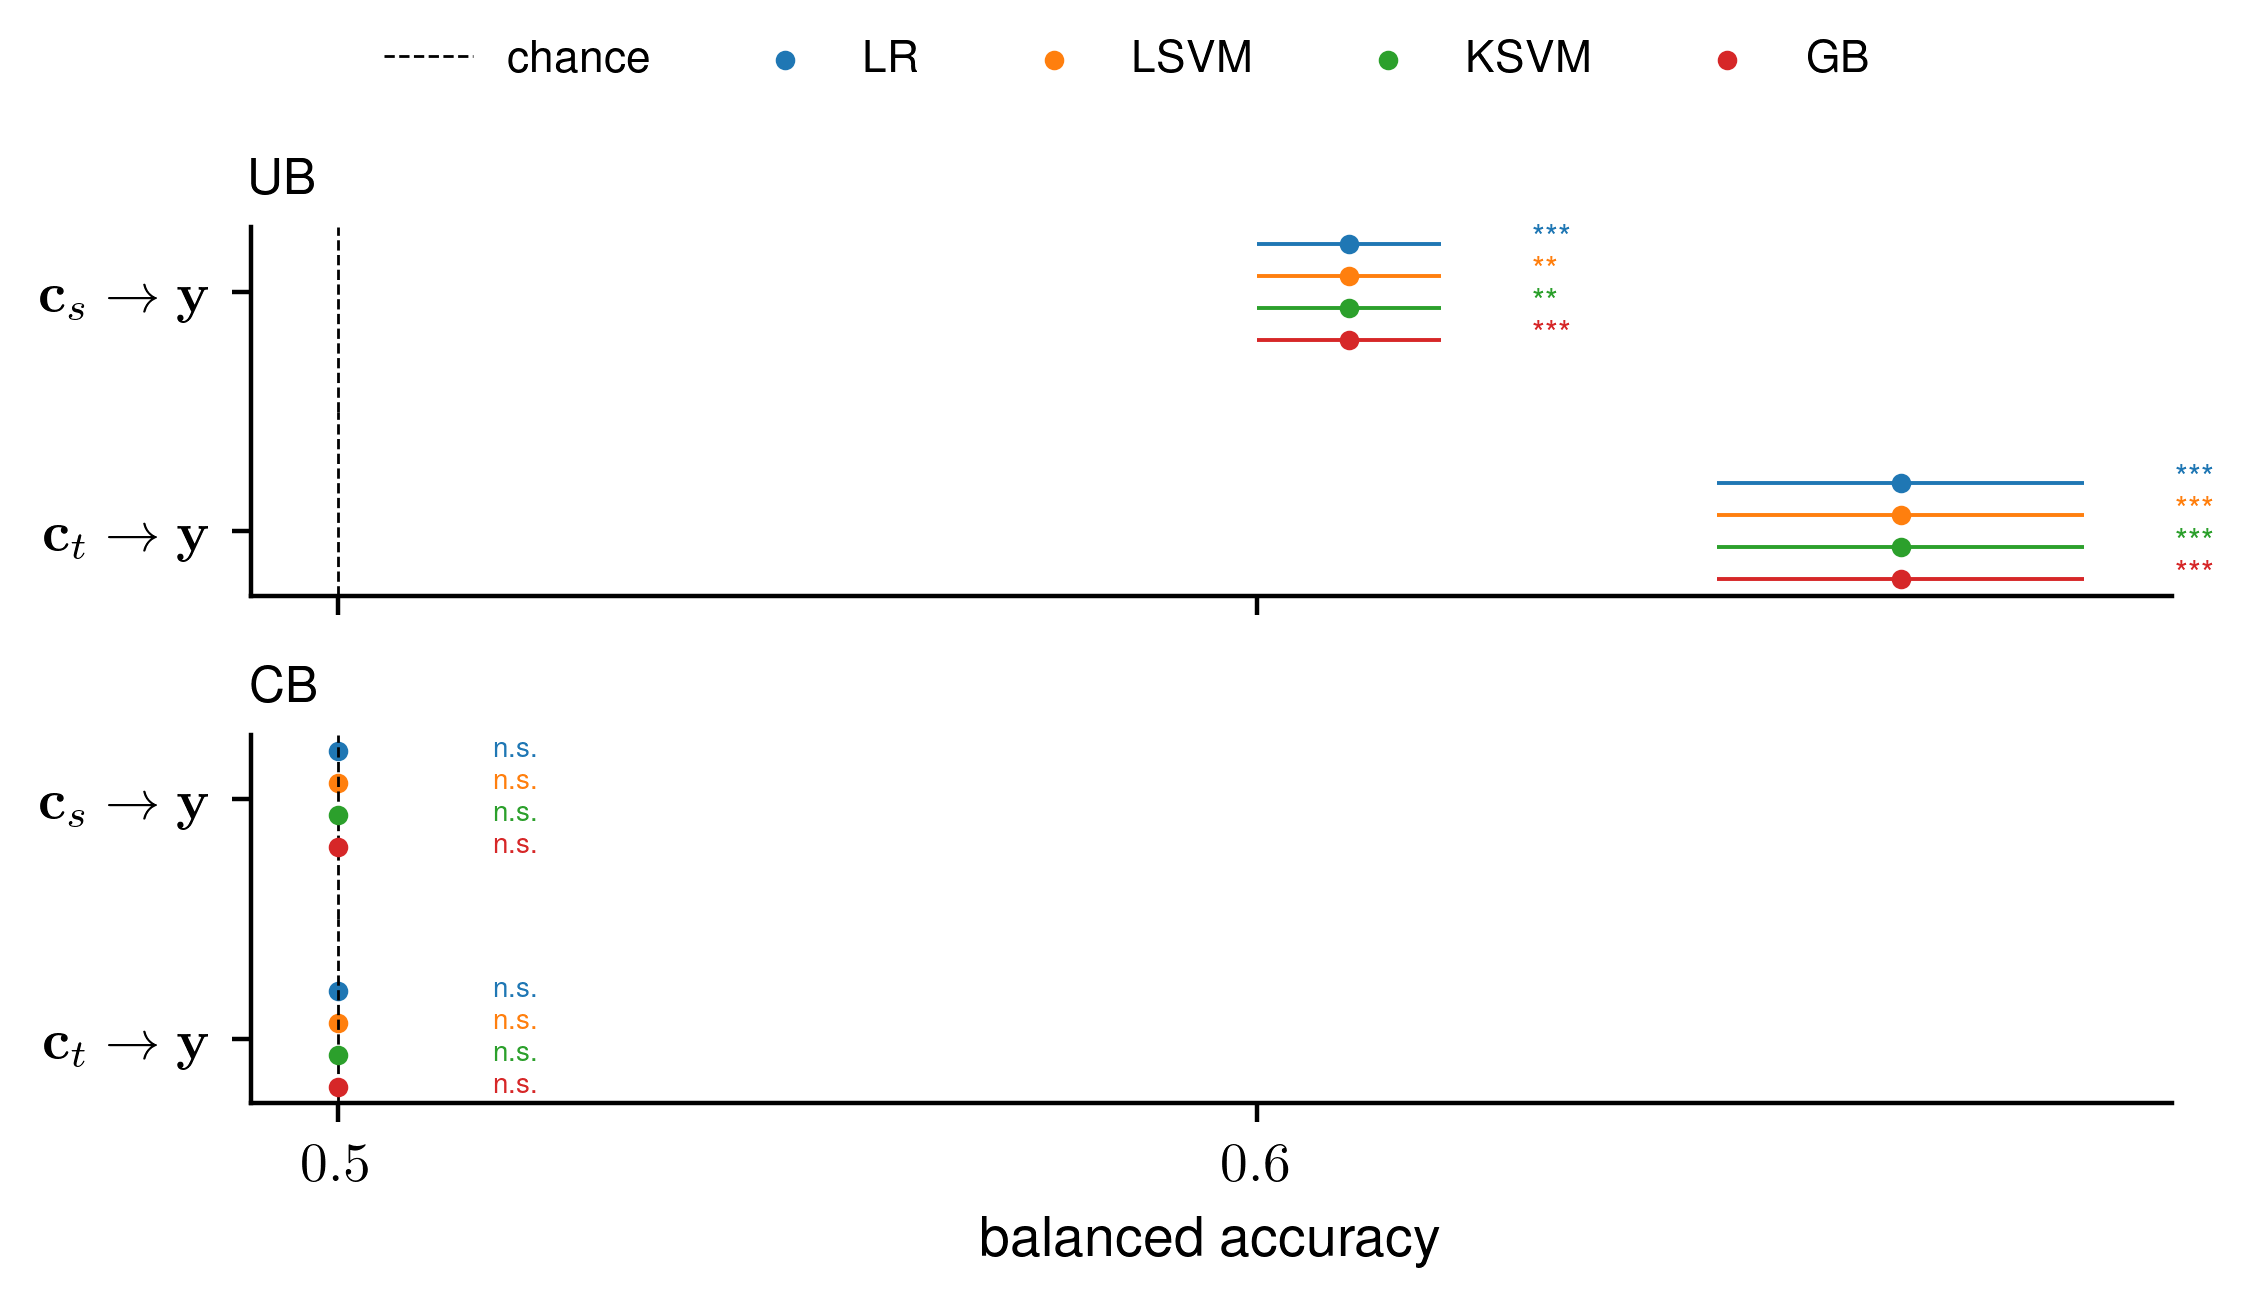

In [7]:
dodge = 0.4
chance = [0.5, 0.5]
yticks = yticks = [
    r"$\mathbf{c}_s \to \mathbf{y}$", 
    r"$\mathbf{c}_t \to \mathbf{y}$"
]

fig, ax = plt.subplots(ncols=1, nrows=2, dpi=400, sharex=True, sharey=True, figsize=(fig_width,3.5))

ax[0].set_title("UB", loc="left", fontsize=9)

ax[1].set_title("CB", loc="left", fontsize=9)


for i, technique in enumerate(["baseline", "cb"]):
        
    setting = "id"

    dfx = dfn.query("technique == '{}' and setting == '{}'".format(technique, setting))
    dfx = dfx.query("model != 'GaussianNB'")

    if technique == "cvcr":
        dodge = 0 

    a = sns.pointplot(y="io", x="ba-mean", hue="model", join=False, data=dfx, \
                            dodge=dodge, scale=posz, errwidth=0.85, ax=ax[i], ci=None, palette=c)

    a.legend_.remove()
    
    ax[i].set_xticks([0.5, 0.6, 0.7])
    ax[i].set_yticklabels(yticks)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")


    n_models = len(dfx["model"].unique())
    dodge_ = np.linspace(0, dodge, n_models) - np.linspace(0, dodge, n_models).mean() 

    n_io = len(dfx.io.unique())
    if chance:
        for z, ch in enumerate(chance):
            ax[i].axvline(x=ch, ymin=z/len(chance),ymax=(z+1)/(len(chance)), label="chance", \
                            c='k', ls='--', lw=0.5)

    # Add errorbars and significance stars 
    for k, io in enumerate(dfx["io"].unique()):
        for m, model in enumerate(dfx["model"].unique()):
            if model != "LogisticRegression" and technique == "cvcr":
                continue
            dfxx = dfx.query("model == '{}' and {} == '{}'".format(model, "io", io))
            test_score = dfxx["ba-mean"].values[0]
            ci_low = dfxx["ba-ci-low"].values[0]
            ci_high = dfxx["ba-ci-high"].values[0]
            pvalue = dfxx["ba-pvalue"].values[0]
            ast = return_asterisks(pvalue)
            err = [[abs(test_score - ci_low)], [abs(test_score-ci_high)]]
            ax[i].errorbar(test_score, k+dodge_[m], xerr=err, c=c[m], elinewidth=lisz)
            if ast == "n.s.":
                ax[i].text(ci_high+0.017, k+dodge_[m]+0.02, r"{}".format(ast), c=c[m], fontsize=5)
            else:
                ax[i].text(ci_high+0.01, k+dodge_[m]+0.02, r"{}".format(ast), c=c[m], fontsize=6)



fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel("balanced accuracy")

handles, _ = ax[i].get_legend_handles_labels()
handles = [handles[i] for i in len(chance)-1 + np.arange(len(dfx["model"].unique())+1)]
fig.legend(handles, ["chance", "LR", "LSVM", "KSVM", "GB"], fontsize=8, frameon=False, loc="upper center",ncol=5)

        
fig.tight_layout()
sns.despine()

plt.subplots_adjust(top=0.85)
plt.show()

# 1. FSS

## 1.1 Combined

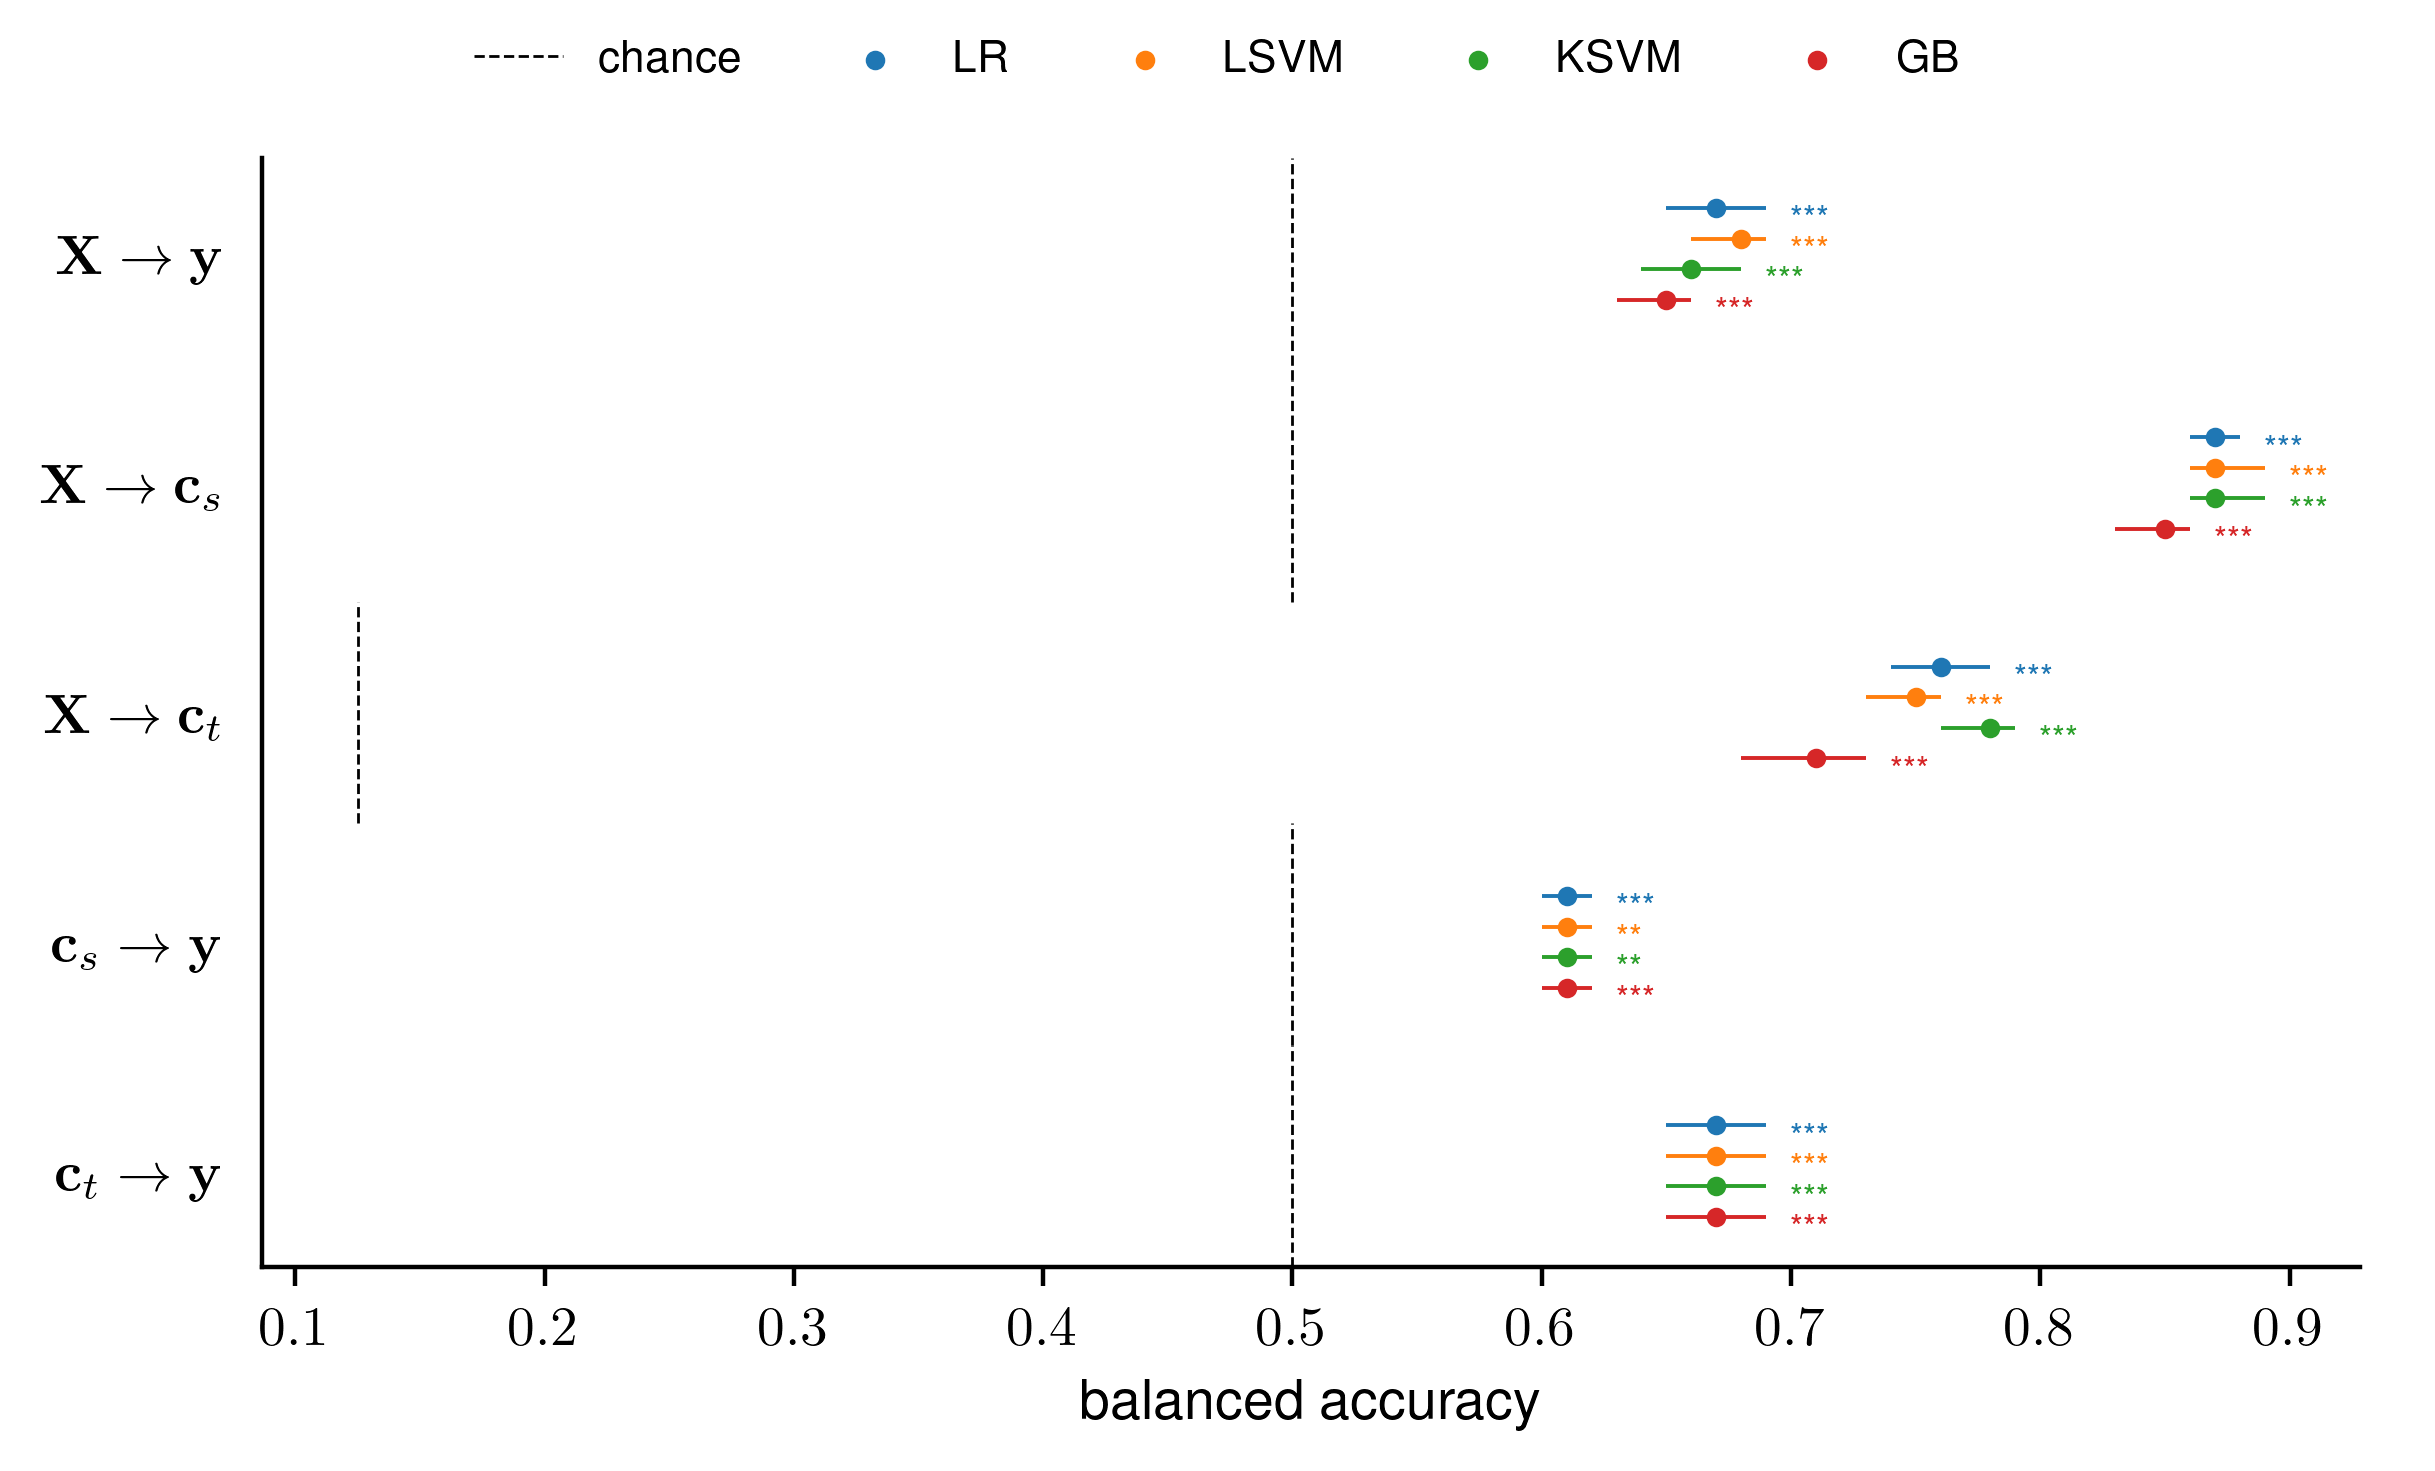

In [8]:
fss_both = pd.read_csv("fss-both.csv")
fss_both = fss_both.rename(columns={
    "ba_mean":"ba-mean",
    "ba_pvalue" : "ba-pvalue",
    "ba_ci_low" : "ba-ci-low",
    "ba_ci_high" : "ba-ci-high"
})
fss_both = fss_both.query("not (technique == 'wdcr' and (io == 'c-y' or io == 's-y'))")
df = fss_both.query("model != 'GaussianNB' and technique == 'baseline'")
dodge = 0.4
yticks = [
    r"$\mathbf{X} \to \mathbf{y}$", 
    r"$\mathbf{X} \to \mathbf{c}_s$", 
    r"$\mathbf{X} \to \mathbf{c}_t$", 
    r"$\mathbf{c}_s \to \mathbf{y}$", 
    r"$\mathbf{c}_t \to \mathbf{y}$"
]
ticks=None
chance = [0.5, 0.5, 0.125, 0.5, 0.5]


fig, ax = plt.subplots(1, 1, figsize=(fig_width,3.5), dpi=400, sharex=True, sharey=True)

    
sett = "id"

dfx = df.query("setting == '{}'".format(sett))

a = sns.pointplot(y="io", x="ba-mean", hue="model", join=False, data=dfx, \
                    dodge=dodge, scale=posz, ax = ax, ci=None, palette=c)

a.legend_.remove()
if yticks:
    ax.set_yticklabels(yticks)

n_io = len(df.io.unique())
if chance:
    for z, ch in enumerate(chance):
        ax.axvline(x=ch, ymin=z/len(chance),ymax=(z+1)/(len(chance)), label="chance", c='k', ls='--', lw=0.5)

ax.set_xlabel("")
ax.set_ylabel("")
if not ticks:
    ax.tick_params(left=False)

n_models = len(dfx["model"].unique())
dodge_ = np.linspace(0, dodge, n_models) - np.linspace(0, dodge, n_models).mean() 

for j, h in enumerate(dfx["io"].unique()):
    for i, m in enumerate(dfx["model"].unique()):
        dfxx = dfx.query("model == '{}' and io == '{}'".format(m, h))
        test_score = dfxx["ba-mean"].values[0]
        ci_low = dfxx["ba-ci-low"].values[0]
        ci_high = dfxx["ba-ci-high"].values[0]
        pvalue = dfxx["ba-pvalue"].values[0]
        ast = return_asterisks(pvalue)
        err = [[abs(test_score - ci_low)], [abs(test_score-ci_high)]]
        ax.errorbar(test_score, j+dodge_[i], xerr=err, c=c[i], elinewidth=lisz)
        if ast == "n.s.":
            ax.text(ci_high+0.02, j+dodge_[i]+0.04, r"{}".format(ast), c=c[i], fontsize=5)
        else:
            ax.text(ci_high+0.01, j+dodge_[i]+0.096, r"{}".format(ast), c=c[i], fontsize=6)


handles, _ = ax.get_legend_handles_labels()
handles = [handles[i] for i in len(chance)-1 + np.arange(len(dfx["model"].unique())+1)]
fig.legend(handles, ["chance", "LR", "LSVM", "KSVM", "GB", "NB"], fontsize=8, frameon=False, loc="upper center",ncol=5)
sns.despine()
fig.tight_layout()

fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel("balanced accuracy")

    # Adjust the scaling factor to fit your legend text completely outside the plot
    # (smaller value results in more space being made for the legend)
plt.subplots_adjust(top=0.9)
plt.savefig("img/fss-b-baseline.png")
plt.show()

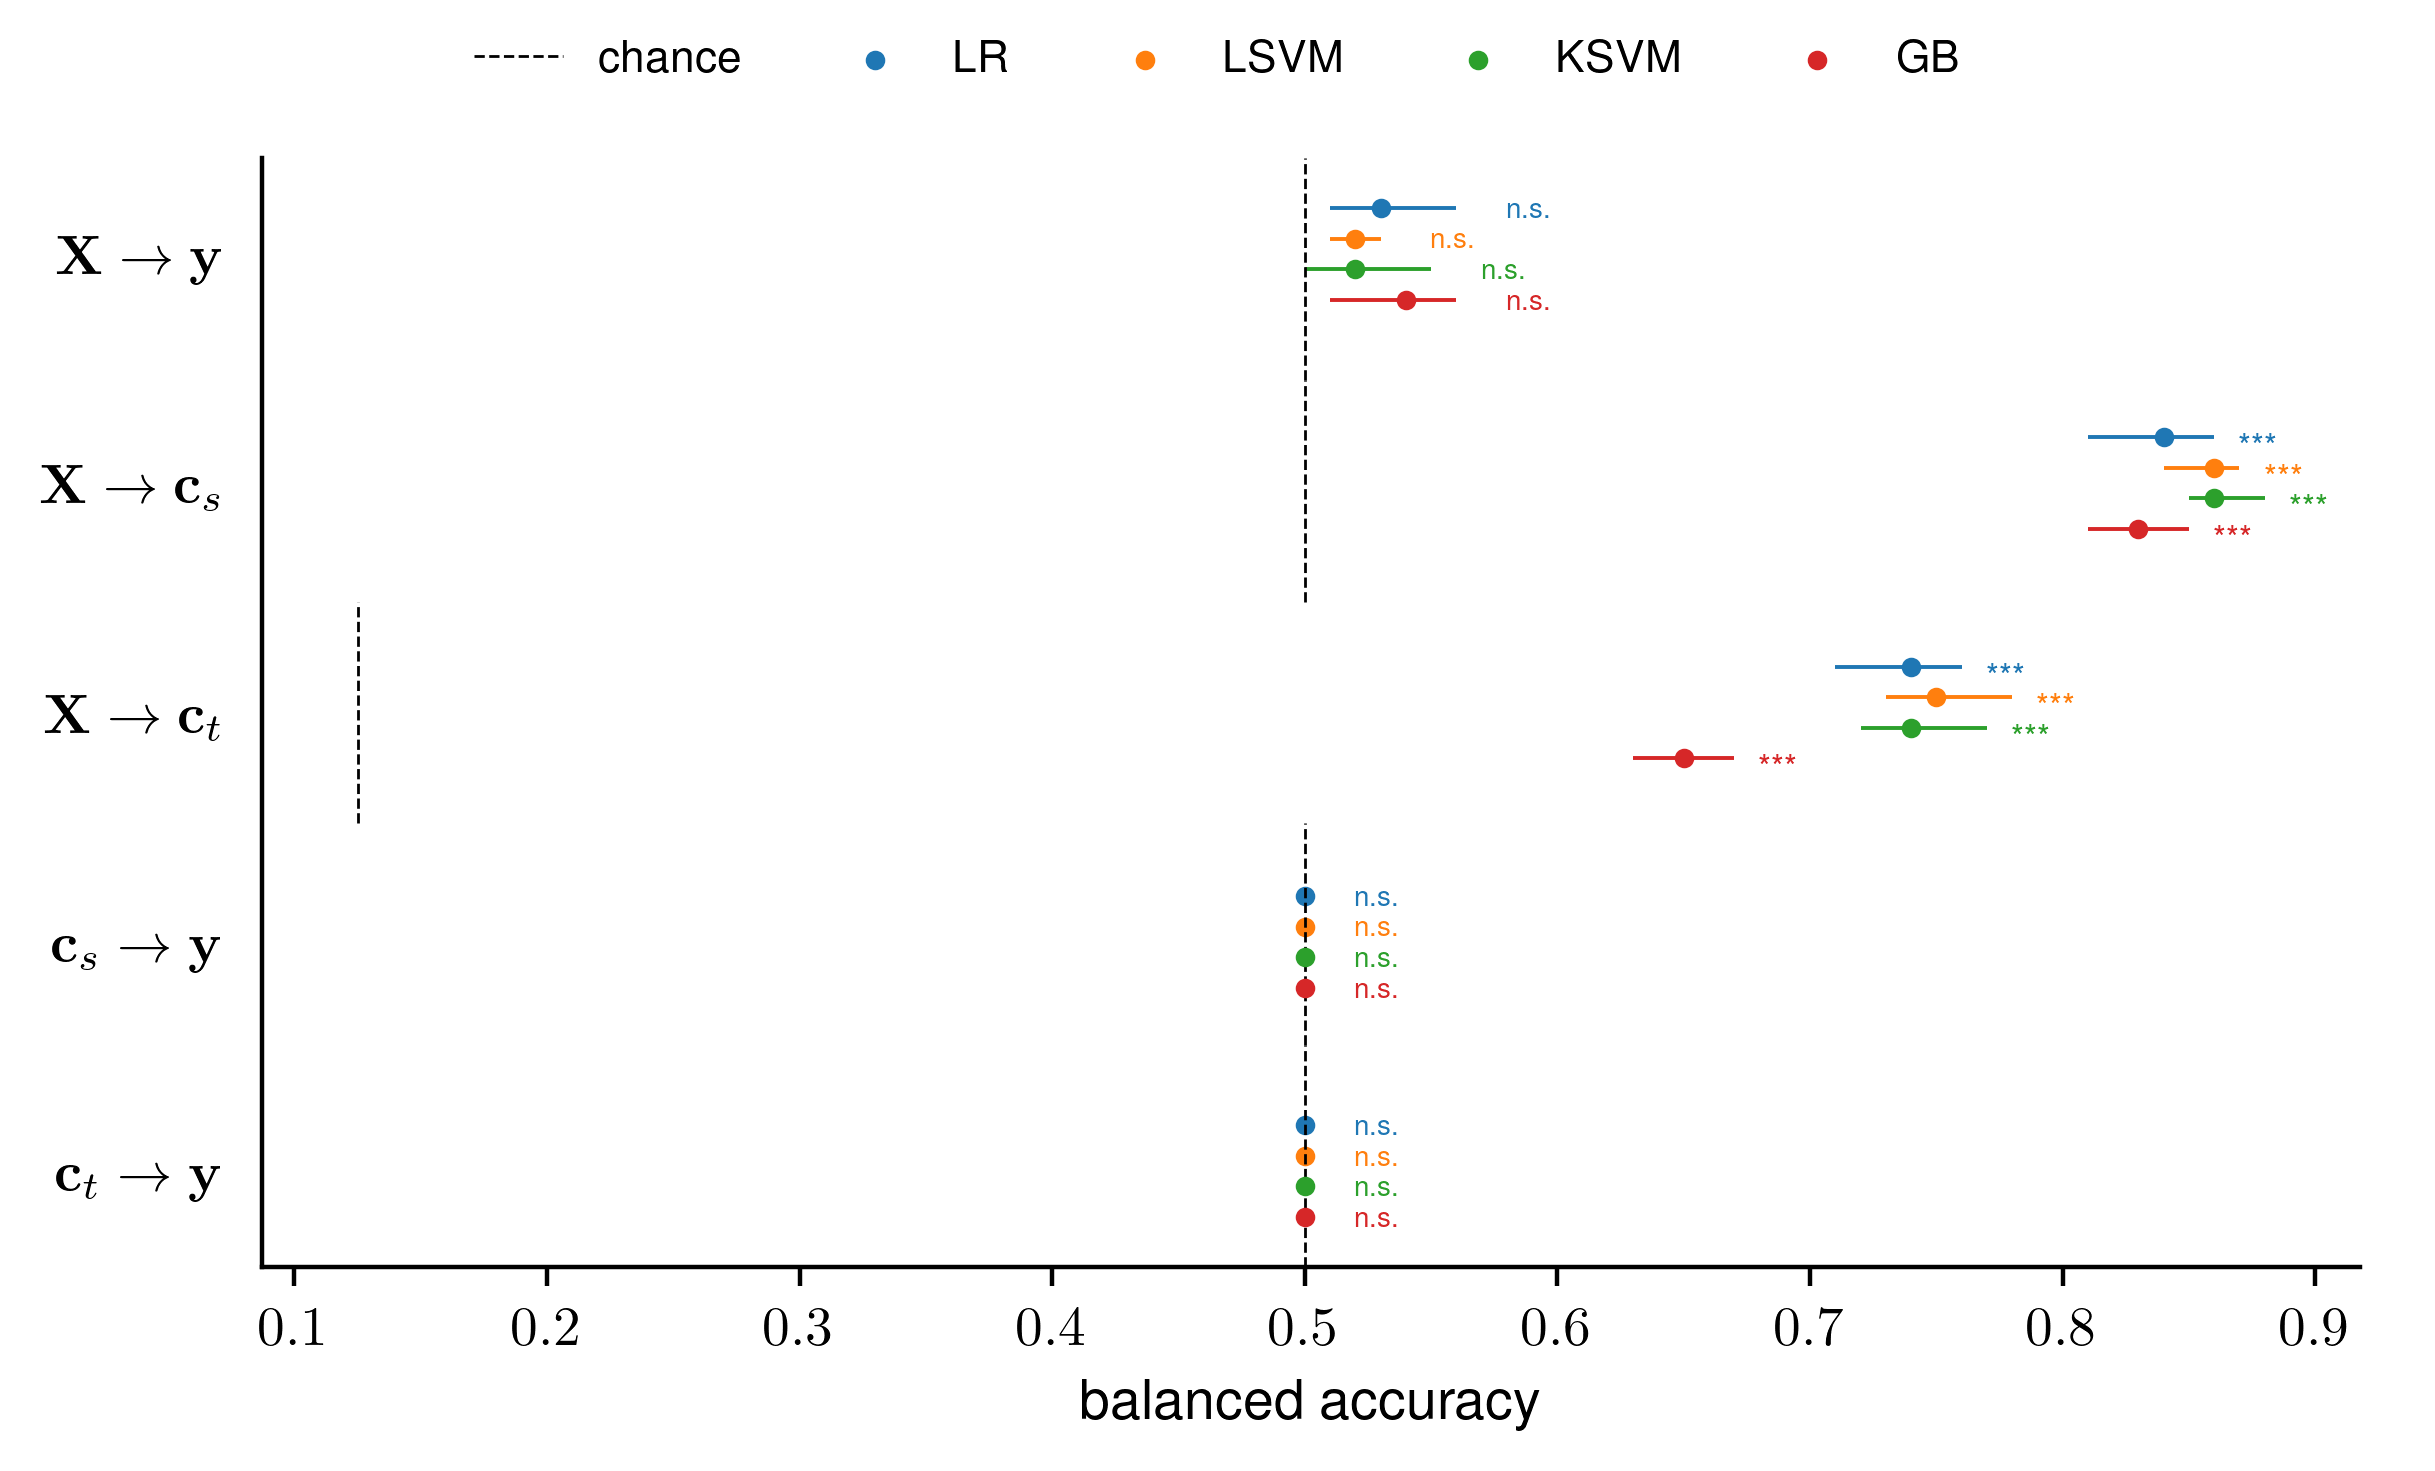

In [9]:
df = fss_both.query("model != 'GaussianNB' and technique == 'cb'")
dodge = 0.4
yticks = [
    r"$\mathbf{X} \to \mathbf{y}$", 
    r"$\mathbf{X} \to \mathbf{c}_s$", 
    r"$\mathbf{X} \to \mathbf{c}_t$", 
    r"$\mathbf{c}_s \to \mathbf{y}$", 
    r"$\mathbf{c}_t \to \mathbf{y}$"
]
ticks=None
chance = [0.5, 0.5, 0.125, 0.5, 0.5]


fig, ax = plt.subplots(1, 1, figsize=(fig_width,3.5), dpi=400, sharex=True, sharey=True)


sett = "id"

dfx = df.query("setting == '{}'".format(sett))

a = sns.pointplot(y="io", x="ba-mean", hue="model", join=False, data=dfx, \
                    dodge=dodge, scale=posz, ax = ax, ci=None, palette=c)

a.legend_.remove()
if yticks:
    ax.set_yticklabels(yticks)

n_io = len(df.io.unique())
if chance:
    for z, ch in enumerate(chance):
        ax.axvline(x=ch, ymin=z/len(chance),ymax=(z+1)/(len(chance)), label="chance", c='k', ls='--', lw=0.5)

ax.set_xlabel("")
ax.set_ylabel("")
if not ticks:
    ax.tick_params(left=False)

n_models = len(dfx["model"].unique())
dodge_ = np.linspace(0, dodge, n_models) - np.linspace(0, dodge, n_models).mean() 

for j, h in enumerate(dfx["io"].unique()):
    for i, m in enumerate(dfx["model"].unique()):
        dfxx = dfx.query("model == '{}' and io == '{}'".format(m, h))
        test_score = dfxx["ba-mean"].values[0]
        ci_low = dfxx["ba-ci-low"].values[0]
        ci_high = dfxx["ba-ci-high"].values[0]
        pvalue = dfxx["ba-pvalue"].values[0]
        ast = return_asterisks(pvalue)
        err = [[abs(test_score - ci_low)], [abs(test_score-ci_high)]]
        ax.errorbar(test_score, j+dodge_[i], xerr=err, c=c[i], elinewidth=lisz)
        if ast == "n.s.":
            ax.text(ci_high+0.02, j+dodge_[i]+0.04, r"{}".format(ast), c=c[i], fontsize=5)
        else:
            ax.text(ci_high+0.01, j+dodge_[i]+0.09, r"{}".format(ast), c=c[i], fontsize=6)


handles, _ = ax.get_legend_handles_labels()
handles = [handles[i] for i in len(chance)-1 + np.arange(len(dfx["model"].unique())+1)]
fig.legend(handles, ["chance", "LR", "LSVM", "KSVM", "GB", "NB"], fontsize=8, frameon=False, loc="upper center", ncol=5)
sns.despine()
fig.tight_layout()

fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel("balanced accuracy")

    # Adjust the scaling factor to fit your legend text completely outside the plot
    # (smaller value results in more space being made for the legend)
plt.subplots_adjust(top=0.9)
plt.savefig("img/fss-b-cb.png")
plt.show()

In [10]:
fss_both = fss_both.append(fss_both.query("(io == 'c-y' or io == 's-y') and technique == 'cvcr'").assign(technique="wdcr"))
fss_both = fss_both.reset_index(drop=True)

In [11]:
fss_both.query("technique == 'wdcr' and io == 's-y'")

,Unnamed: 0,model,technique,io,ba-mean,ba_std,ba-ci-low,ba-ci-high,ba-pvalue,sens,spec,auc_ci_high,auc_ci_low,auc_mean,auc_pvalue,inmod,setting,sex
230,18,LogisticRegression,wdcr,s-y,0.61,0.05,0.58,0.63,0.001998,0.56,0.65,0.634571,0.578377,0.61,0.008991,fs-stats,pr,both
232,43,LinearSVC,wdcr,s-y,0.61,0.05,0.58,0.63,0.007992,0.56,0.65,0.634297,0.578215,0.61,0.010989,fs-stats,pr,both
234,68,SVC,wdcr,s-y,0.61,0.05,0.58,0.63,0.001998,0.56,0.65,0.634235,0.577131,0.61,0.002997,fs-stats,pr,both
236,93,GradientBoostingClassifier,wdcr,s-y,0.61,0.05,0.58,0.63,0.000999,0.56,0.65,0.633786,0.577019,0.61,0.007992,fs-stats,pr,both
238,118,GaussianNB,wdcr,s-y,0.61,0.05,0.58,0.63,0.007992,0.56,0.65,0.634920,0.577817,0.61,0.010989,fs-stats,pr,both
240,143,LogisticRegression,wdcr,s-y,0.61,0.02,0.60,0.62,0.000999,0.59,0.63,0.618889,0.597037,0.61,0.000999,fs-stats,id,both
242,168,LinearSVC,wdcr,s-y,0.61,0.02,0.60,0.62,0.001998,0.59,0.63,0.618889,0.597130,0.61,0.001998,fs-stats,id,both
244,193,SVC,wdcr,s-y,0.61,0.02,0.60,0.62,0.000999,0.59,0.63,0.618981,0.597315,0.61,0.000999,fs-stats,id,both
246,218,GradientBoostingClassifier,wdcr,s-y,0.61,0.02,0.60,0.62,0.000999,0.59,0.63,0.618796,0.597407,0.61,0.001998,fs-stats,id,both
248,243,GaussianNB,wdcr,s-y,0.61,0.02,0.60,0.62,0.000999,0.59,0.63,0.618704,0.597315,0.61,0.000999,fs-stats,id,both


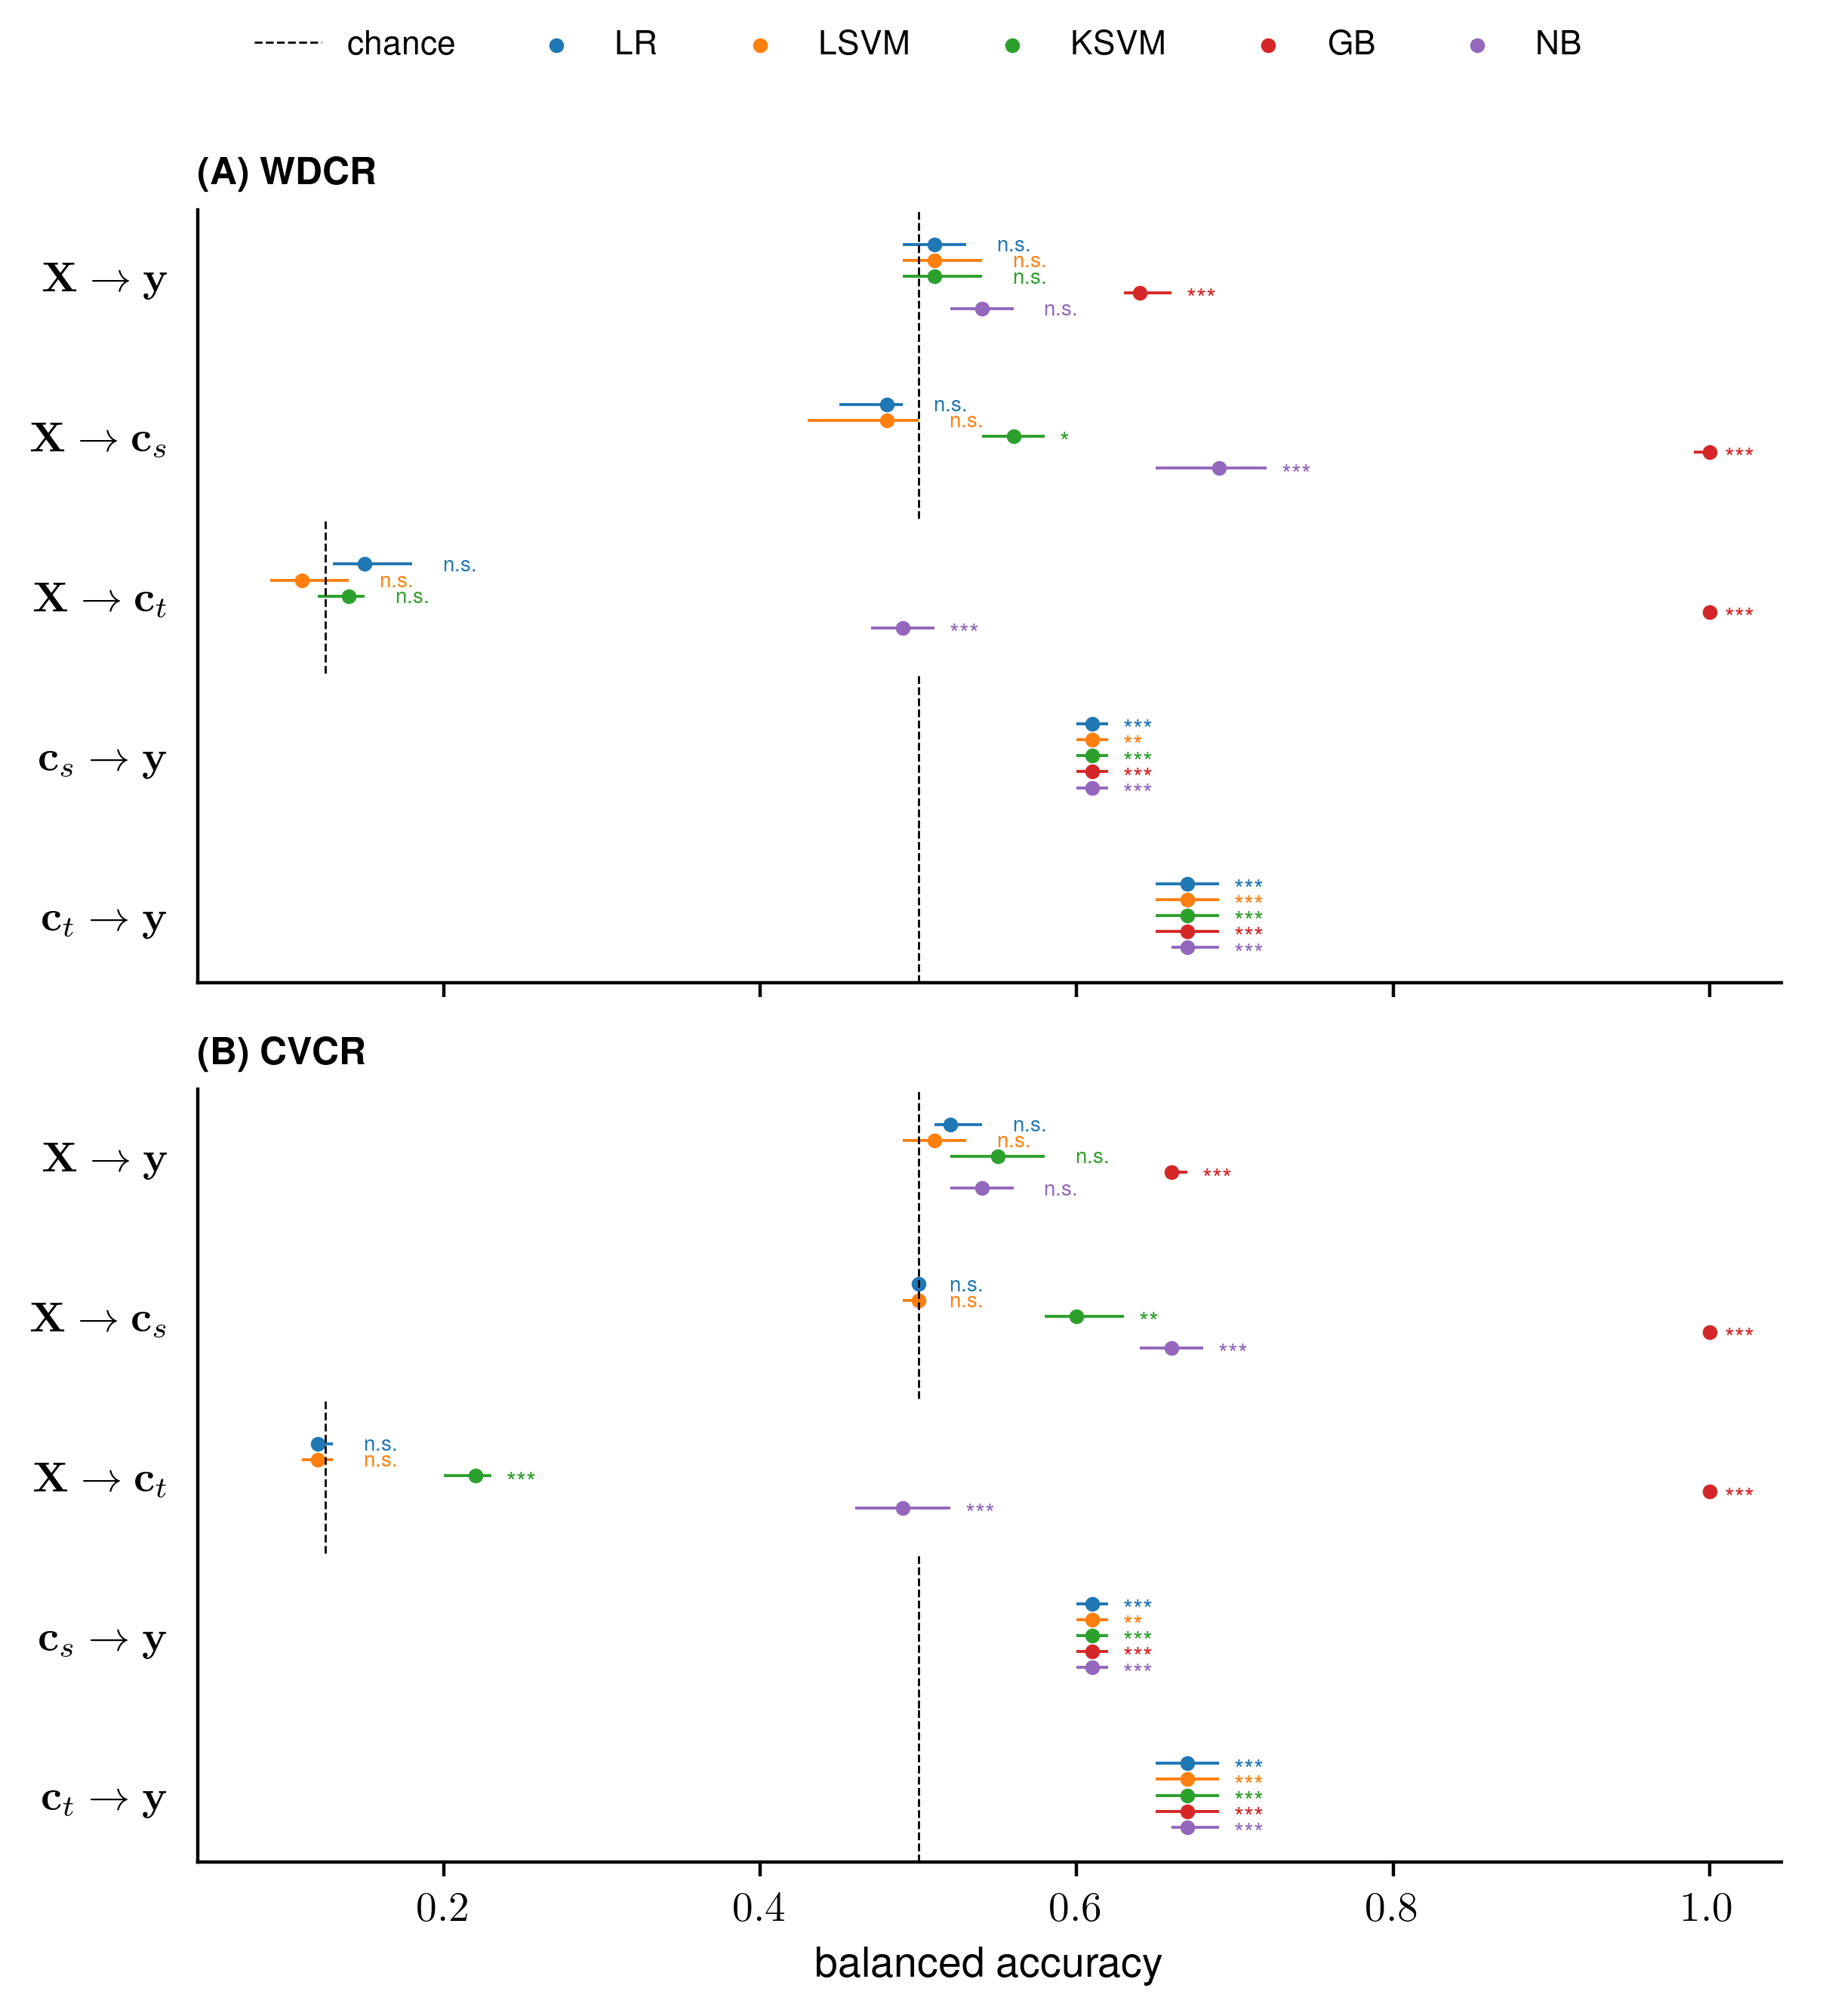

In [12]:
df = fss_both#.query("model != 'GaussianNB'")
df = df.query("technique == 'wdcr' or technique == 'cvcr'")
#df = df.query("io == 'X-y' or (io == 'X-c' or io == 'X-s')")
df = df.rename(columns={"ba_mean":"ba-mean"})
dodge = 0.4
yticks = [
    r"$\mathbf{X} \to \mathbf{y}$", 
    r"$\mathbf{X} \to \mathbf{c}_s$", 
    r"$\mathbf{X} \to \mathbf{c}_t$", 
    r"$\mathbf{c}_s \to \mathbf{y}$", 
    r"$\mathbf{c}_t \to \mathbf{y}$"
]
ticks=None
chance = [0.5, 0.5, 0.125, 0.5, 0.5]


fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(fig_width,6.5), dpi=400, sharex=True, sharey=True)

for t, technique in enumerate(["wdcr", "cvcr"]):
    sett = "id"

    dfx = df.query("setting == '{}' and technique == '{}'".format(sett, technique))

    a = sns.pointplot(y="io", x="ba-mean", hue="model", join=False, data=dfx, \
                        dodge=dodge, scale=posz, ax = ax[t], ci=None, palette=c)

    a.legend_.remove()
    if yticks:
        ax[t].set_yticklabels(yticks)

    n_io = len(df.io.unique())
    if chance:
        for z, ch in enumerate(chance):
            ax[t].axvline(x=ch, ymin=z/len(chance),ymax=(z+1)/(len(chance)), \
                            label="chance", c='k', ls='--', lw=0.5)

    ax[t].set_xlabel("")
    ax[t].set_ylabel("")
    if not ticks:
        ax[t].tick_params(left=False)

    n_models = len(dfx["model"].unique())
    dodge_ = np.linspace(0, dodge, n_models) - np.linspace(0, dodge, n_models).mean() 

    for j, h in enumerate(dfx["io"].unique()):
        for i, m in enumerate(dfx["model"].unique()):
            dfxx = dfx.query("model == '{}' and io == '{}'".format(m, h))
            test_score = dfxx["ba-mean"].values[0]
            ci_low = dfxx["ba-ci-low"].values[0]
            ci_high = dfxx["ba-ci-high"].values[0]
            pvalue = dfxx["ba-pvalue"].values[0]
            ast = return_asterisks(pvalue)
            err = [[abs(test_score - ci_low)], [abs(test_score-ci_high)]]
            ax[t].errorbar(test_score, j+dodge_[i], xerr=err, c=c[i], elinewidth=lisz)
            if ast == "n.s.":
                ax[t].text(ci_high+0.02, j+dodge_[i]+0.04, r"{}".format(ast), c=c[i], fontsize=5)
            else:
                ax[t].text(ci_high+0.01, j+dodge_[i]+0.09, r"{}".format(ast), c=c[i], fontsize=6)

ax[0].set_title(r"\textbf{(A) WDCR}", fontsize=9, loc="left")
ax[1].set_title(r"\textbf{(B) CVCR}", fontsize=9, loc="left")


handles, _ = ax[t].get_legend_handles_labels()
handles = [handles[i] for i in len(chance)-1 + np.arange(len(dfx["model"].unique())+1)]
fig.legend(handles, ["chance", "LR", "LSVM", "KSVM", "GB", "NB"], fontsize=8, frameon=False,\
           loc="upper center", ncol=6)
sns.despine()
fig.tight_layout()

fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel("balanced accuracy")

plt.subplots_adjust(top = 0.9)
plt.savefig("img/fss-b-cr.png")
plt.show()

In [12]:
# Maybe visualize CBCVCR ? 

## 1.2 Females

In [13]:
fss_1 = pd.read_csv("fss-females.csv")
fss_1 = fss_1.rename(columns={
    "ba_mean" : "ba-mean",
    "ba_ci_low" : "ba-ci-low",
    "ba_ci_high" : "ba-ci-high", 
    "ba_pvalue" : "ba-pvalue"
})

In [14]:
yticks = [
    r"$\mathbf{X} \to \mathbf{y}$", 
    r"$\mathbf{X} \to \mathbf{c}_t$", 
    r"$\mathbf{c}_t \to \mathbf{y}$"
]

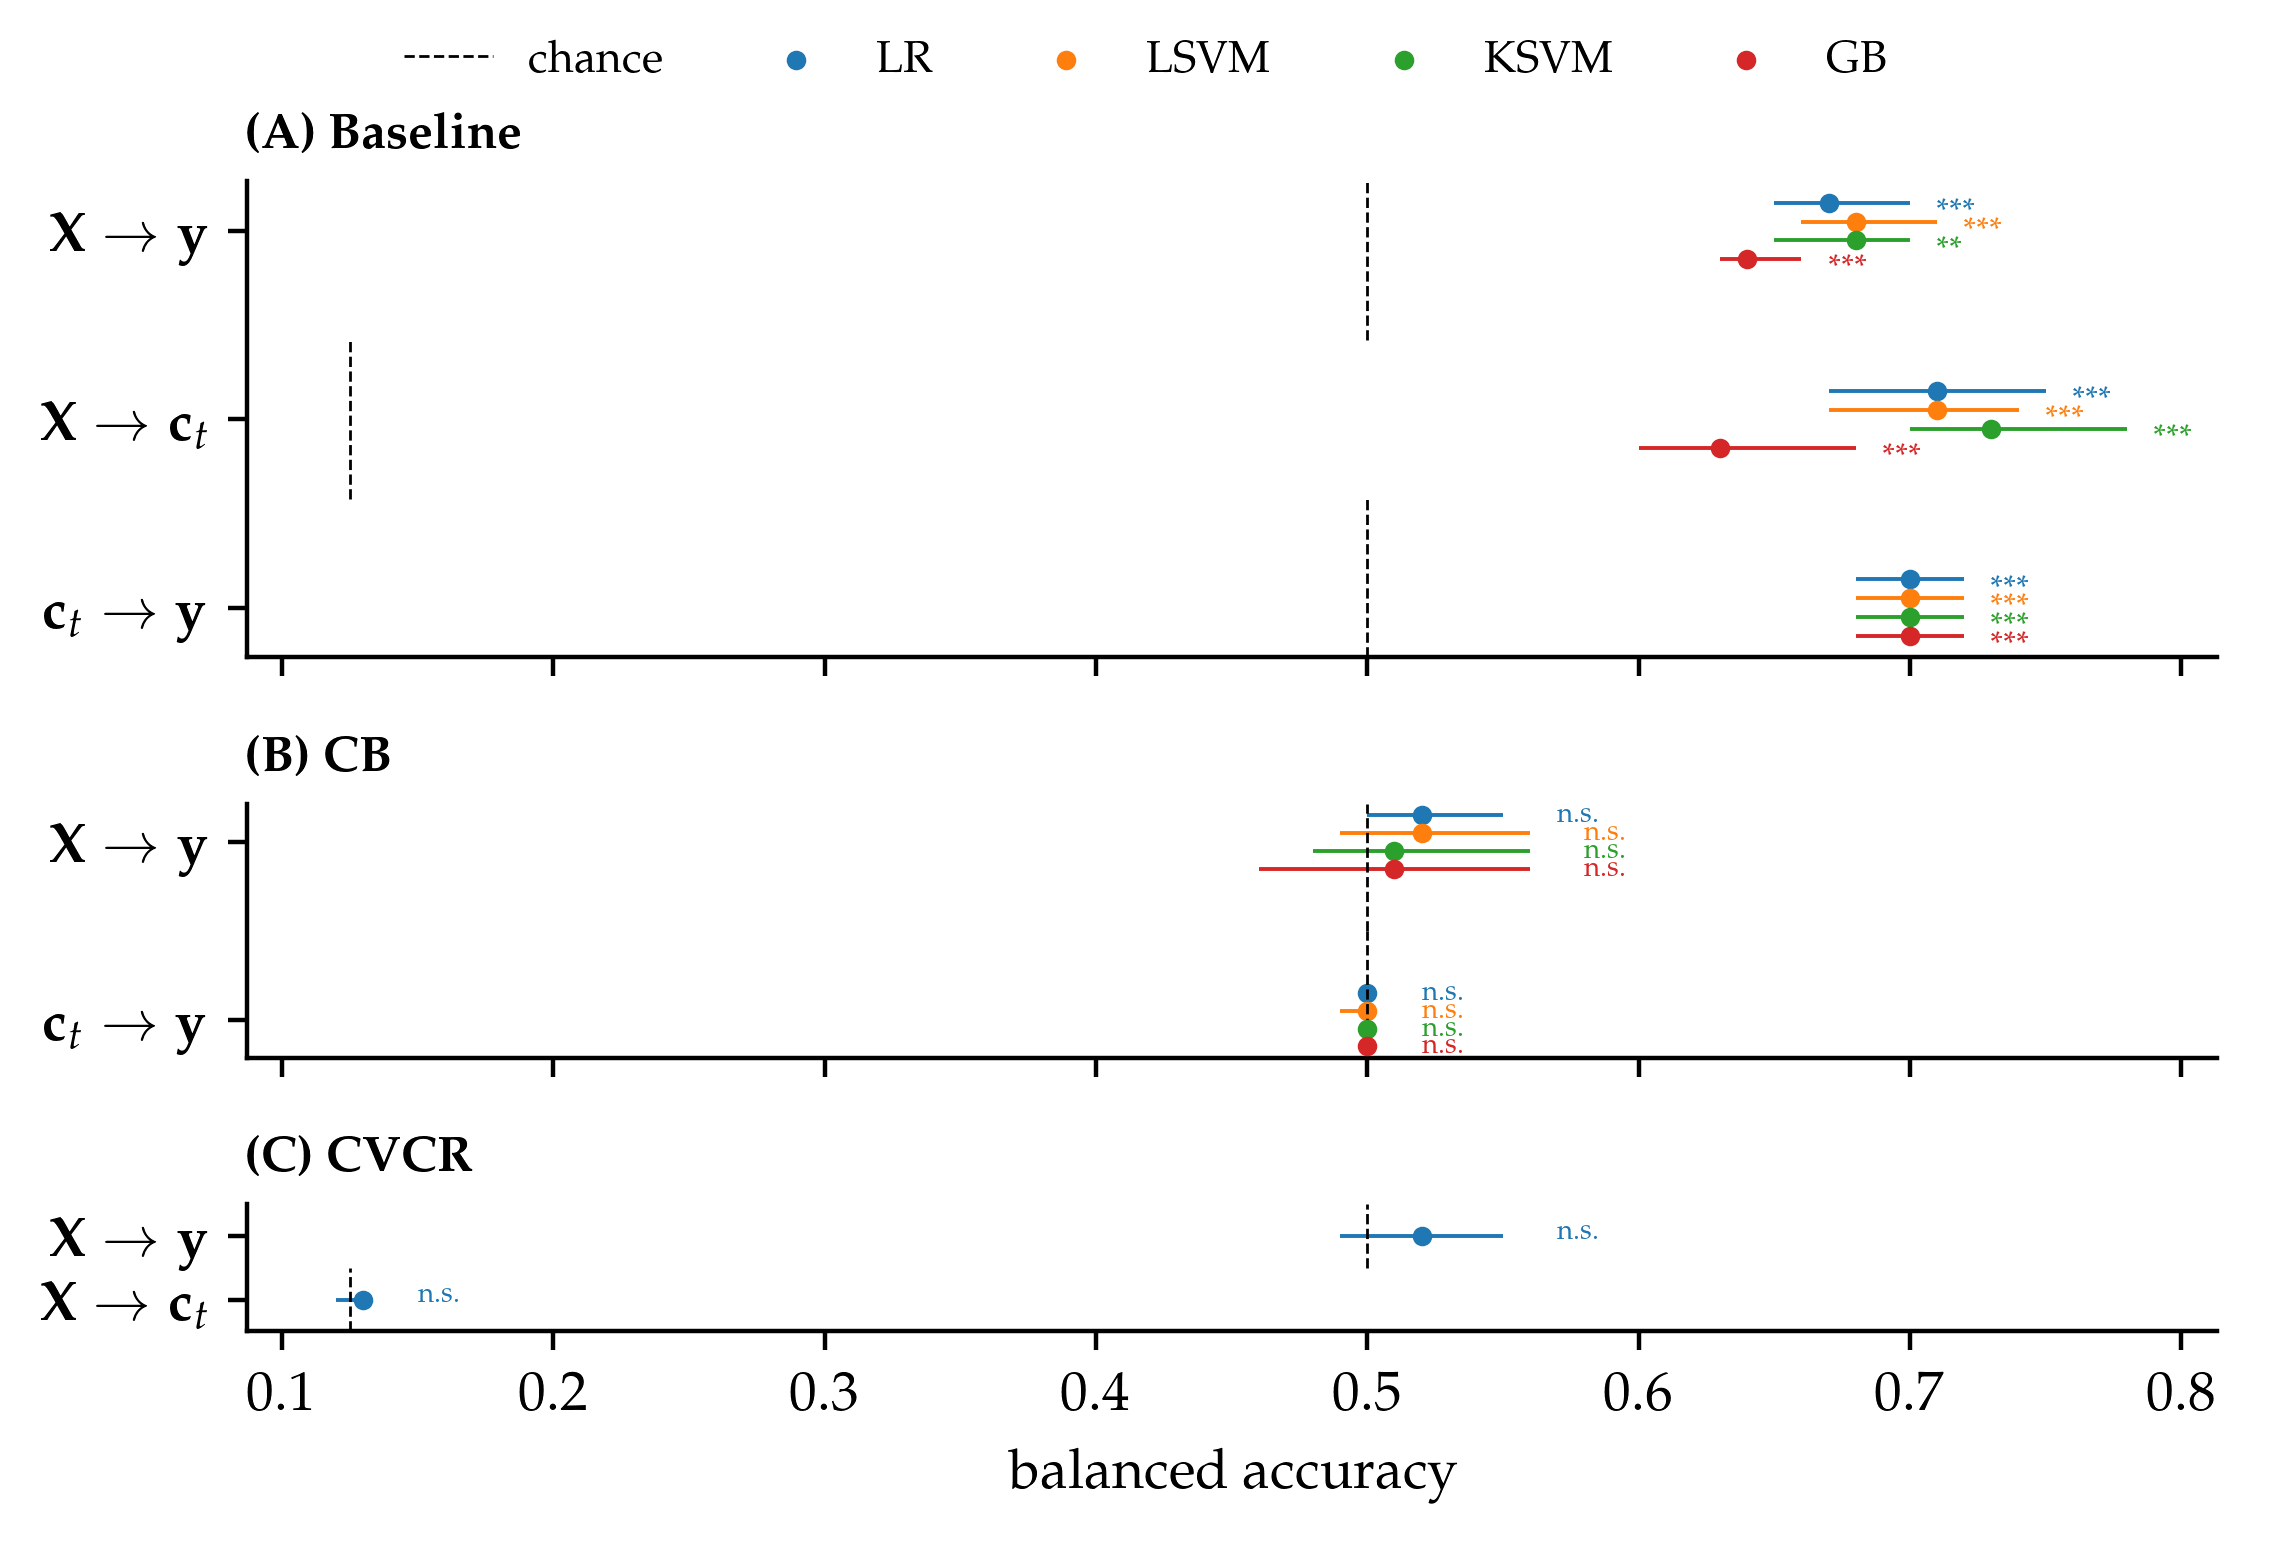

In [15]:
c = sns.color_palette()
dodge = 0.3

fig, ax = plt.subplots(ncols=1, nrows=3, dpi=400, sharex=True, sharey=False, figsize=(fig_width,4.1),\
                      gridspec_kw={'height_ratios': [3,1.6,0.8]})

for i, technique in enumerate(["baseline", "cb", "cvcr"]):
    setting = "id"
        
    dfx = fss_1.query("technique == '{}' and setting == '{}'".format(technique, setting))
    dfx = dfx.query("model != 'GaussianNB'")
    
    if technique == "baseline":
        chance = [0.5, 0.125, 0.5]
        dodge = 0.3
        yticks = [
            r"$\mathbf{X} \to \mathbf{y}$", 
            r"$\mathbf{X} \to \mathbf{c}_t$", 
            r"$\mathbf{c}_t \to \mathbf{y}$"
        ]
        #ax[i].set_ylim([-1, 4])
    elif technique == "cvcr":
        chance = [0.125, 0.5]
        dodge = 0
        dfx = dfx.query("io == 'X-y' or io == 'X-c'")
        yticks = [
            r"$\mathbf{X} \to \mathbf{y}$", 
            r"$\mathbf{X} \to \mathbf{c}_t$"
        ]
        ax[i].set_ylim([-1, 3])
    elif technique == "cb":
        chance = [0.5, 0.5]
        dodge = 0.3
        dfx = dfx.query("io == 'X-y' or io == 'c-y'")
        yticks = [
            r"$\mathbf{X} \to \mathbf{y}$", 
            r"$\mathbf{c}_t \to \mathbf{y}$"
        ]
        #ax[i].set_ylim([-0.5, 2.5])

    a = sns.pointplot(y="io", x="ba-mean", hue="model", join=False, data=dfx, \
                            dodge=dodge, scale=posz, errwidth=0.85, ax=ax[i], ci=None, palette=c)

    a.legend_.remove()

    ax[i].set_yticklabels(yticks)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")


    n_models = len(dfx["model"].unique())
    dodge_ = np.linspace(0, dodge, n_models) - np.linspace(0, dodge, n_models).mean() 

    n_io = len(dfx.io.unique())
    if chance:
        for z, ch in enumerate(chance):
            ax[i].axvline(x=ch, ymin=z/len(chance),ymax=(z+1)/(len(chance)), label="chance", \
                            c='k', ls='--', lw=0.5)

    # Add errorbars and significance stars 
    for k, io in enumerate(dfx["io"].unique()):
        for m, model in enumerate(dfx["model"].unique()):
            if model != "LogisticRegression" and technique == "cvcr":
                continue
            dfxx = dfx.query("model == '{}' and {} == '{}'".format(model, "io", io))
            test_score = dfxx["ba-mean"].values[0]
            ci_low = dfxx["ba-ci-low"].values[0]
            ci_high = dfxx["ba-ci-high"].values[0]
            pvalue = dfxx["ba-pvalue"].values[0]
            ast = return_asterisks(pvalue)
            err = [[abs(test_score - ci_low)], [abs(test_score-ci_high)]]
            ax[i].errorbar(test_score, k+dodge_[m], xerr=err, c=c[m], elinewidth=lisz)
            if ast == "n.s.":
                ax[i].text(ci_high+0.02, k+dodge_[m]+0.04, r"{}".format(ast), c=c[m], fontsize=5)
            else:
                ax[i].text(ci_high+0.01, k+dodge_[m]+0.095, r"{}".format(ast), c=c[m], fontsize=6)


ax[0].set_title(r"\textbf{(A) Baseline}", fontsize=9, loc="left")
ax[1].set_title(r"\textbf{(B) CB}", fontsize=9, loc="left")
ax[2].set_title(r"\textbf{(C) CVCR}", fontsize=9, loc="left")


fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel("balanced accuracy")

handles, _ = ax[i].get_legend_handles_labels()
handles = [handles[i] for i in len(chance)-1 + np.arange(len(dfx["model"].unique())+1)]
fig.legend(handles, ["chance", "LR", "LSVM", "KSVM", "GB"], fontsize=8, frameon=False, loc="upper center", ncol=5)

        
fig.tight_layout()
sns.despine()

plt.subplots_adjust(top=0.9)
plt.savefig("img/fss-1.png")
plt.show()

## 1.3 Males

In [16]:
fss_0 = pd.read_csv("fss-males.csv")
fss_0 = fss_0.rename(columns={
    "ba_mean" : "ba-mean",
    "ba_ci_low" : "ba-ci-low",
    "ba_ci_high" : "ba-ci-high", 
    "ba_pvalue" : "ba-pvalue"
})

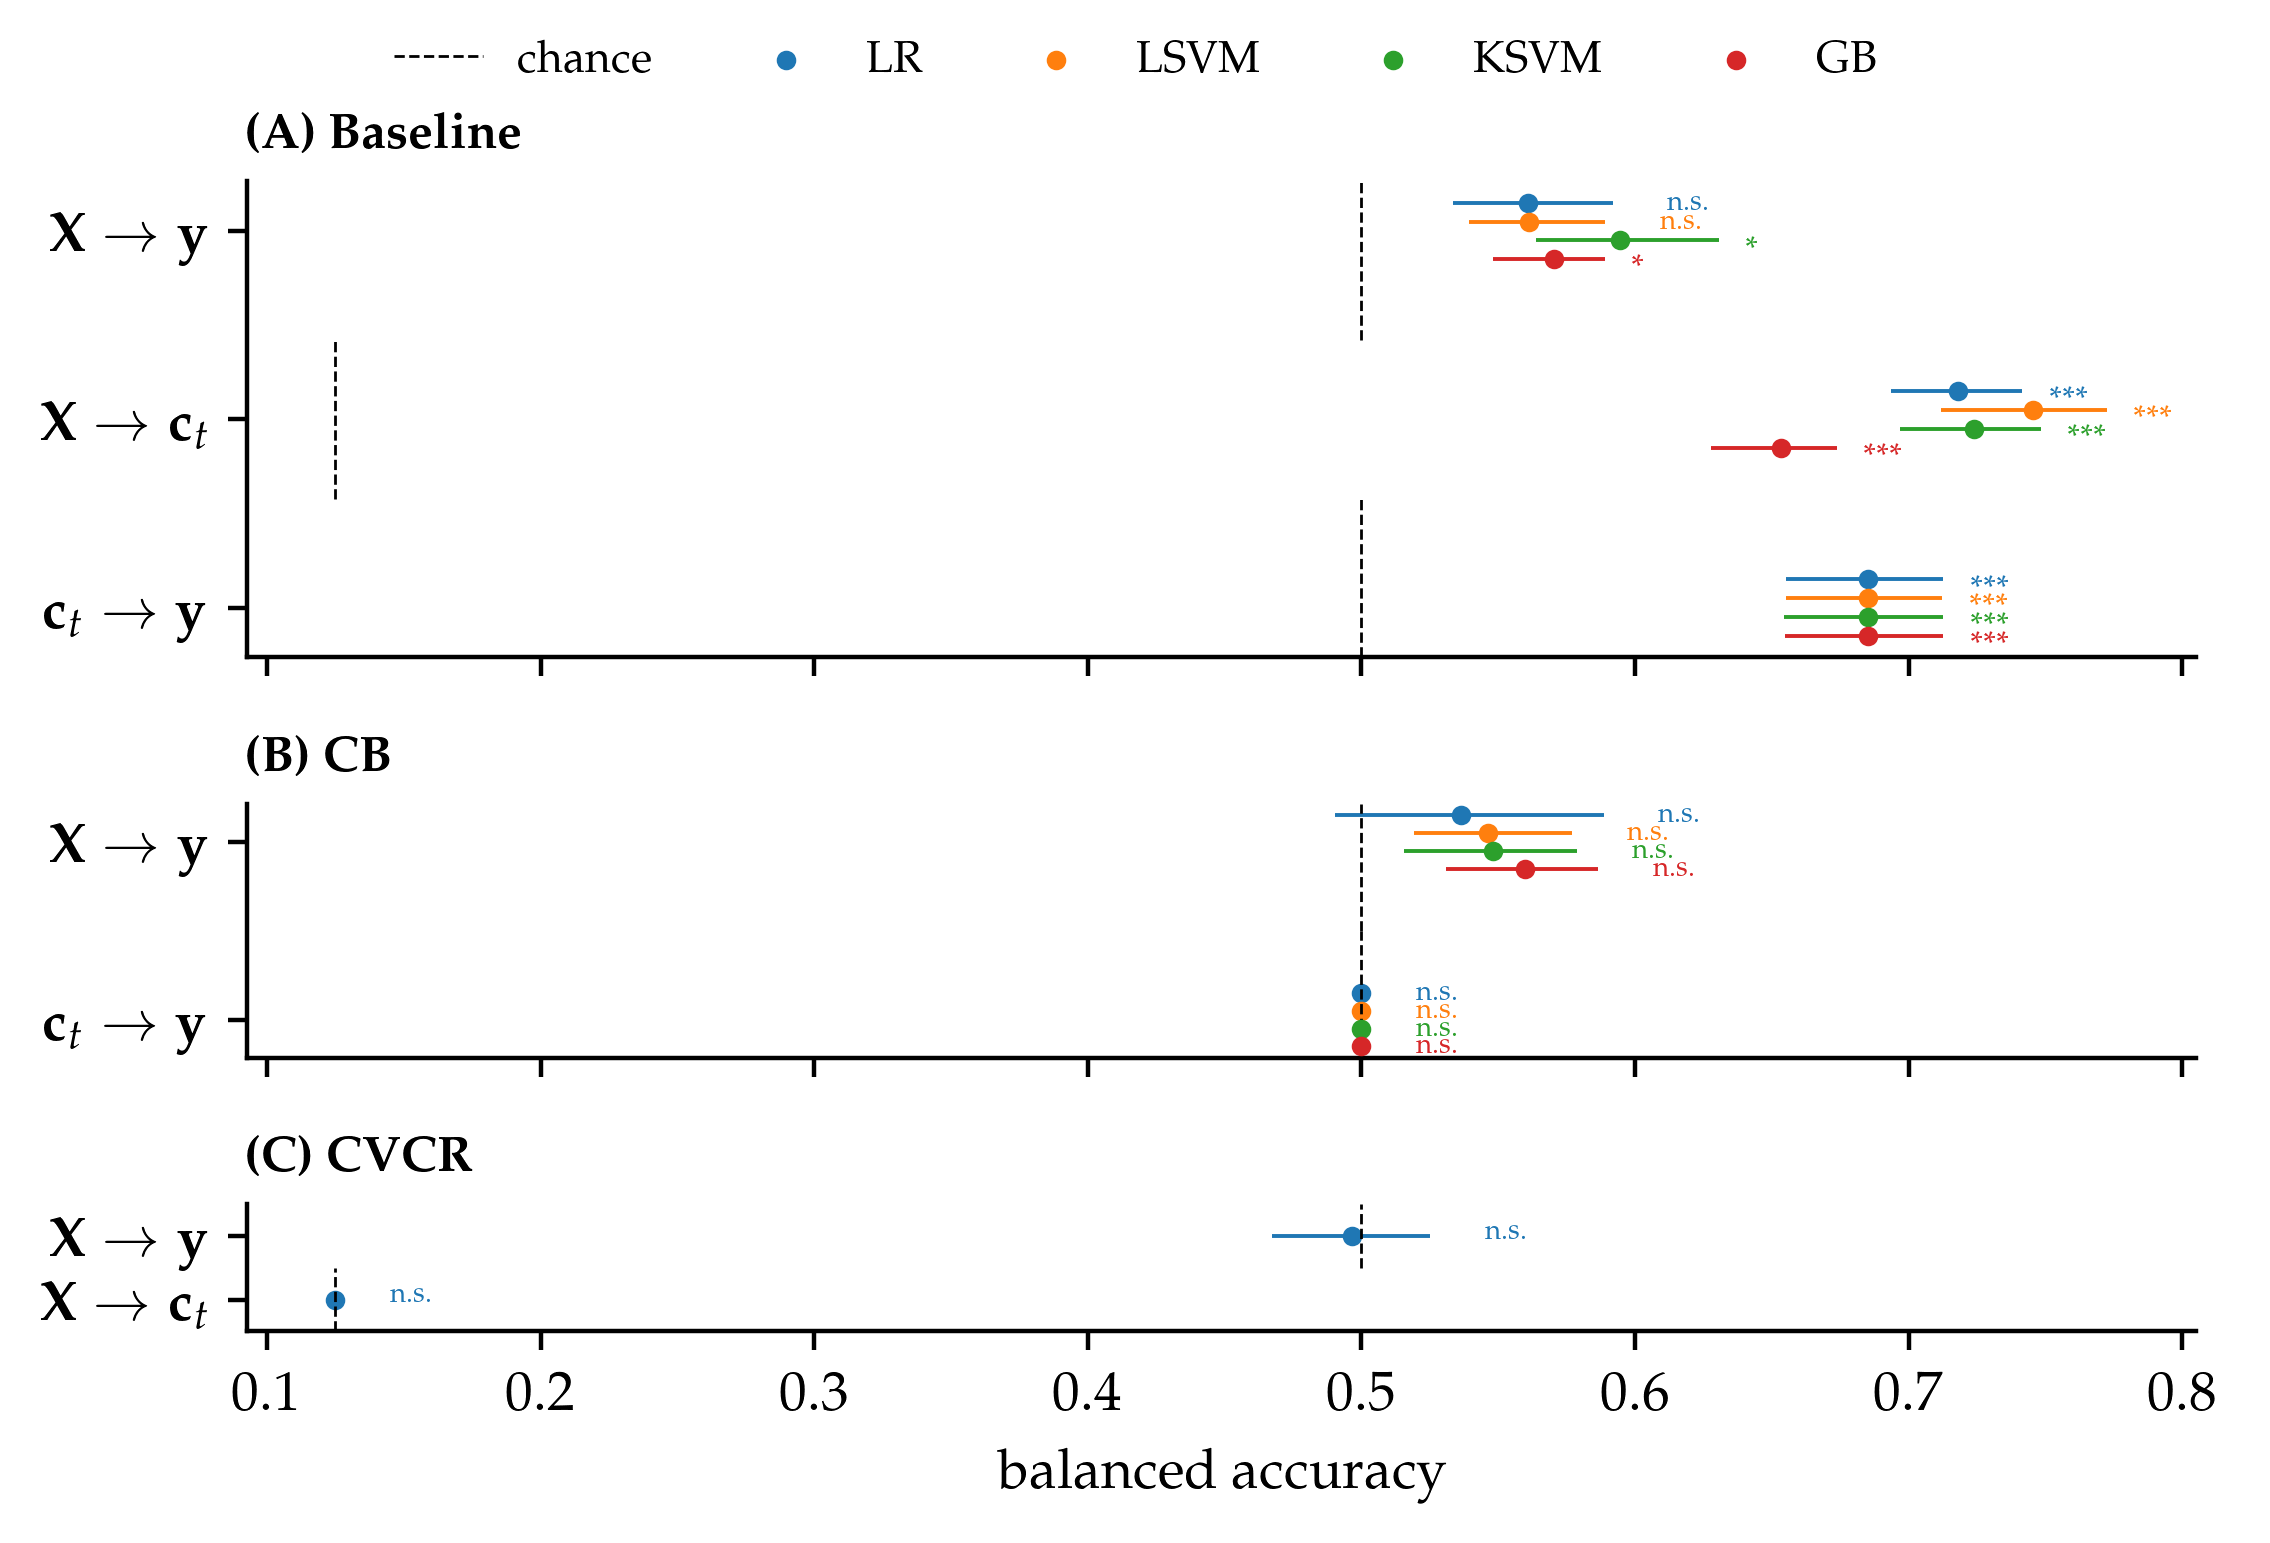

In [17]:
c = sns.color_palette()
dodge = 0.3
chance = [0.5, 0.125, 0.5]


fig, ax = plt.subplots(ncols=1, nrows=3, dpi=400, sharex=True, sharey=False, figsize=(fig_width,4.1),\
                      gridspec_kw={'height_ratios': [3,1.6,0.8]})

for i, technique in enumerate(["baseline", "cb", "cvcr"]):
    setting = "id"
        
    dfx = fss_0.query("technique == '{}' and setting == '{}'".format(technique, setting))
    dfx = dfx.query("model != 'GaussianNB'")

    if technique == "baseline":
        chance = [0.5, 0.125, 0.5]
        dodge = 0.3
        yticks = [
            r"$\mathbf{X} \to \mathbf{y}$", 
            r"$\mathbf{X} \to \mathbf{c}_t$", 
            r"$\mathbf{c}_t \to \mathbf{y}$"
        ]

    elif technique == "cvcr":
        chance = [0.125, 0.5]
        dodge = 0
        dfx = dfx.query("io == 'X-y' or io == 'X-c'")
        yticks = [
            r"$\mathbf{X} \to \mathbf{y}$", 
            r"$\mathbf{X} \to \mathbf{c}_t$"
        ]
        ax[i].set_ylim([-1, 3])
    elif technique == "cb":
        chance = [0.5, 0.5]
        dodge = 0.3
        dfx = dfx.query("io == 'X-y' or io == 'c-y'")
        yticks = [
            r"$\mathbf{X} \to \mathbf{y}$", 
            r"$\mathbf{c}_t \to \mathbf{y}$"
        ]

    a = sns.pointplot(y="io", x="ba-mean", hue="model", join=False, data=dfx, \
                            dodge=dodge, scale=posz, errwidth=0.85, ax=ax[i], ci=None, palette=c)

    a.legend_.remove()

    ax[i].set_yticklabels(yticks)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")


    n_models = len(dfx["model"].unique())
    dodge_ = np.linspace(0, dodge, n_models) - np.linspace(0, dodge, n_models).mean() 

    n_io = len(dfx.io.unique())
    if chance:
        for z, ch in enumerate(chance):
            ax[i].axvline(x=ch, ymin=z/len(chance),ymax=(z+1)/(len(chance)), label="chance", \
                            c='k', ls='--', lw=0.5)

    # Add errorbars and significance stars 
    for k, io in enumerate(dfx["io"].unique()):
        for m, model in enumerate(dfx["model"].unique()):
            if model != "LogisticRegression" and technique == "cvcr":
                continue
            dfxx = dfx.query("model == '{}' and {} == '{}'".format(model, "io", io))
            test_score = dfxx["ba-mean"].values[0]
            ci_low = dfxx["ba-ci-low"].values[0]
            ci_high = dfxx["ba-ci-high"].values[0]
            pvalue = dfxx["ba-pvalue"].values[0]
            ast = return_asterisks(pvalue)
            err = [[abs(test_score - ci_low)], [abs(test_score-ci_high)]]
            ax[i].errorbar(test_score, k+dodge_[m], xerr=err, c=c[m], elinewidth=lisz)
            if ast == "n.s.":
                ax[i].text(ci_high+0.02, k+dodge_[m]+0.04, r"{}".format(ast), c=c[m], fontsize=5)
            else:
                ax[i].text(ci_high+0.01, k+dodge_[m]+0.095, r"{}".format(ast), c=c[m], fontsize=6)


ax[0].set_title(r"\textbf{(A) Baseline}", fontsize=9, loc="left")
ax[1].set_title(r"\textbf{(B) CB}", fontsize=9, loc="left")
ax[2].set_title(r"\textbf{(C) CVCR}", fontsize=9, loc="left")


fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel("balanced accuracy")

handles, _ = ax[i].get_legend_handles_labels()
handles = [handles[i] for i in len(chance)-1 + np.arange(len(dfx["model"].unique())+1)]
fig.legend(handles, ["chance", "LR", "LSVM", "KSVM", "GB"], fontsize=8, frameon=False, loc="upper center", ncol=5)

        
fig.tight_layout()
sns.despine()

plt.subplots_adjust(top=0.9)
plt.savefig("img/fss-0.png")
plt.show()

# 2. T1w

In [18]:
t1wb = pd.read_csv("t1w-both.csv")
t1wb = t1wb.rename(columns={
    "ba_mean":"ba-mean",
    "ba_ci_low" : "ba-ci-low",
    "ba_ci_high" : "ba-ci-high", 
    "ba_pvalue" : "ba-pvalue"
})

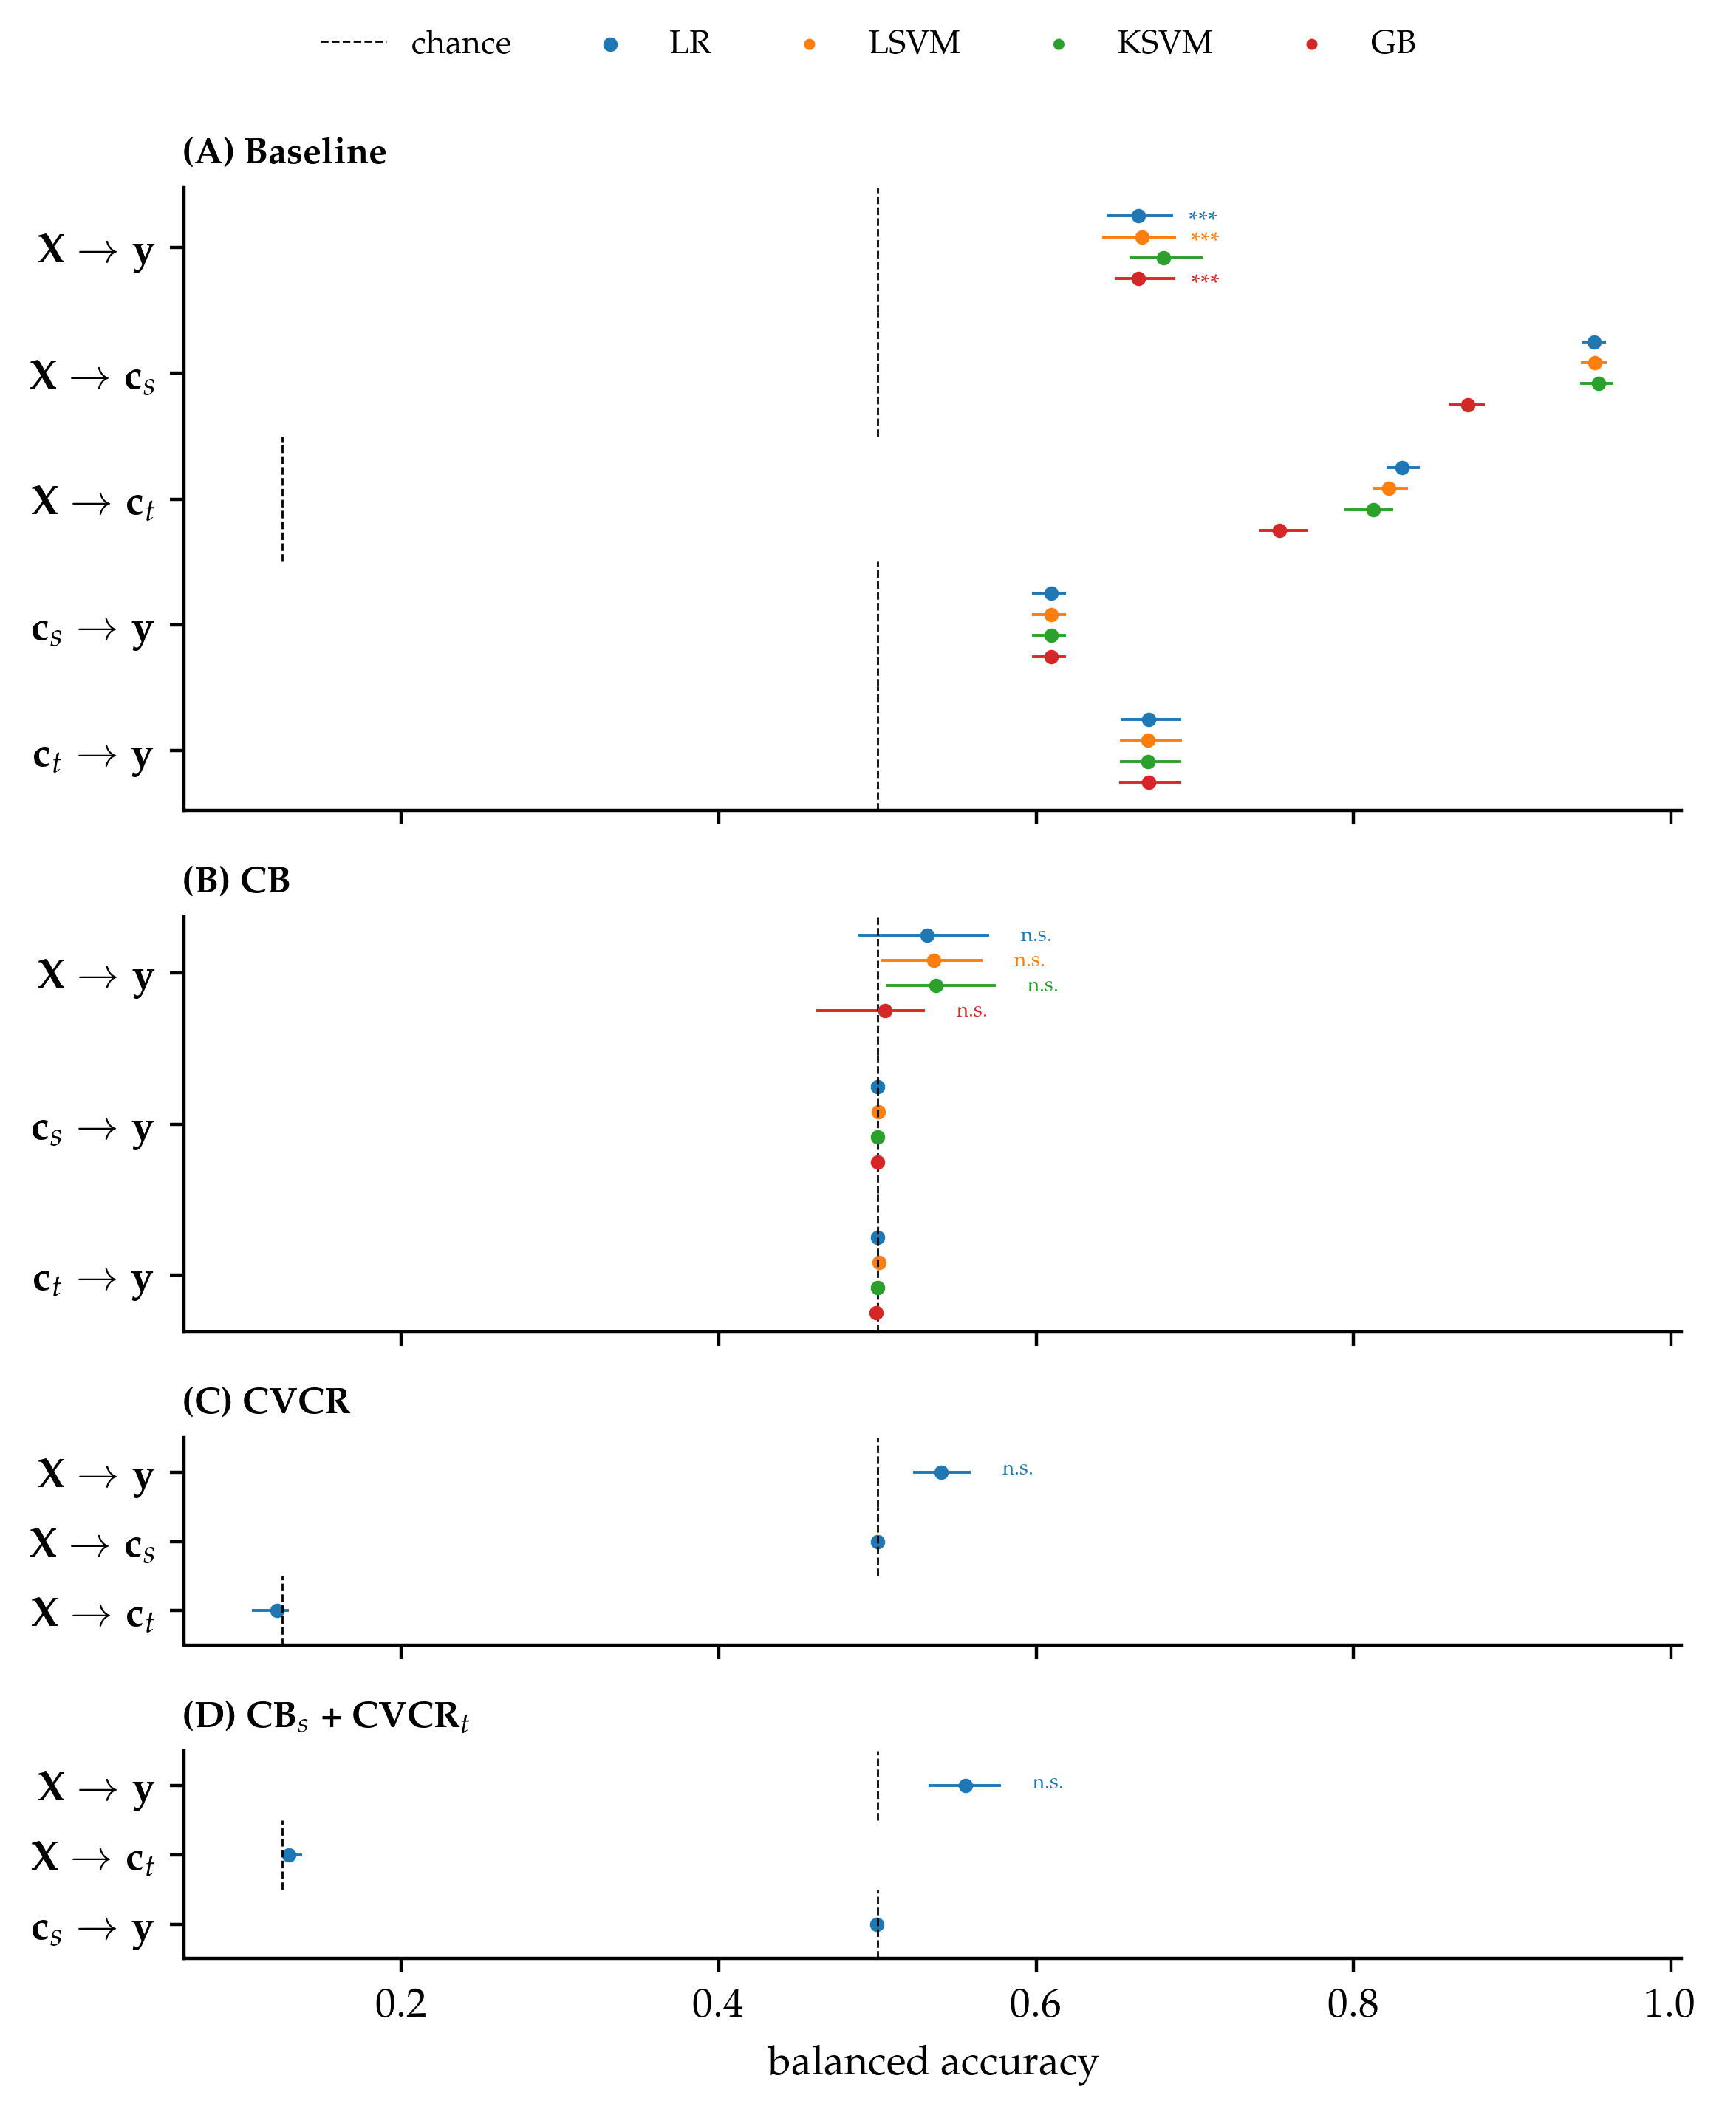

In [19]:
fig, ax = plt.subplots(ncols=1, nrows=4, dpi=400, sharex=True, sharey=False, figsize=(6.3,7.4),\
                      gridspec_kw={'height_ratios': [3,2, 1, 1]})



for i, technique in enumerate(["baseline", "cb", "cvcr", "cbcvcr"]):
    setting = "id"
        
    dfx = t1wb.query("technique == '{}' and setting == '{}'".format(technique, setting))
    dfx = dfx.query("model != 'GaussianNB'")

    if technique == "baseline":
        chance = [0.5, 0.5, 0.125, 0.5, 0.5]
        dodge = 0.5
        yticks = [
            r"$\mathbf{X} \to \mathbf{y}$", 
            r"$\mathbf{X} \to \mathbf{c}_s$", 
            r"$\mathbf{X} \to \mathbf{c}_t$", 
            r"$\mathbf{c}_s \to \mathbf{y}$",
            r"$\mathbf{c}_t \to \mathbf{y}$"
        ]
    elif technique == "cb":
        chance = [0.5, 0.5, 0.5]
        dodge = 0.5
        dfx = dfx.query("(io == 'X-y' or io == 'c-y') or io == 's-y'")
        yticks = [
            r"$\mathbf{X} \to \mathbf{y}$", 
            r"$\mathbf{c}_s \to \mathbf{y}$",
            r"$\mathbf{c}_t \to \mathbf{y}$"
        ]
    elif technique == "cvcr":
        chance = [0.125, 0.5, 0.5]
        dodge = 0
        dfx = dfx.query("(io == 'X-y' or io == 'X-c') or io == 'X-s'")
        yticks = [
            r"$\mathbf{X} \to \mathbf{y}$", 
            r"$\mathbf{X} \to \mathbf{c}_s$",
            r"$\mathbf{X} \to \mathbf{c}_t$"
        ]
        ax[i].set_ylim([-1, 3])
    elif technique == "cbcvcr":
        dfx = dfx.query("(io == 'X-y' or io == 'X-c') or io == 's-y'")
        chance = [0.5, 0.125, 0.5]
        dodge = 0
        yticks = [
            r"$\mathbf{X} \to \mathbf{y}$", 
            r"$\mathbf{X} \to \mathbf{c}_t$", 
            r"$\mathbf{c}_s \to \mathbf{y}$"
        ]
        ax[i].set_ylim([-1, 3])
        


    a = sns.pointplot(y="io", x="ba-mean", hue="model", join=False, data=dfx, \
                            dodge=dodge, scale=posz, errwidth=0.85, ax=ax[i], ci=None, palette=c)

    a.legend_.remove()

    ax[i].set_yticklabels(yticks)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")


    n_models = len(dfx["model"].unique())
    dodge_ = np.linspace(0, dodge, n_models) - np.linspace(0, dodge, n_models).mean() 

    n_io = len(dfx.io.unique())
    if chance:
        for z, ch in enumerate(chance):
            ax[i].axvline(x=ch, ymin=z/len(chance),ymax=(z+1)/(len(chance)), label="chance", \
                            c='k', ls='--', lw=0.5)

    # Add errorbars and significance stars 
    for k, io in enumerate(dfx["io"].unique()):
        for m, model in enumerate(dfx["model"].unique()):
            if model != "LogisticRegression" and (technique == "cvcr" or technique == "cbcvcr"):
                continue
            dfxx = dfx.query("model == '{}' and {} == '{}'".format(model, "io", io))
            test_score = dfxx["ba-mean"].values[0]
            ci_low = dfxx["ba-ci-low"].values[0]
            ci_high = dfxx["ba-ci-high"].values[0]
            pvalue = dfxx["ba-pvalue"].values[0]

            err = [[abs(test_score - ci_low)], [abs(test_score-ci_high)]]
            ax[i].errorbar(test_score, k+dodge_[m], xerr=err, c=c[m], elinewidth=lisz)
            if (not np.isnan(pvalue)) and (io == 'X-y'):
                ast = return_asterisks(pvalue)
                if ast == "n.s.":
                    ax[i].text(ci_high+0.02, k+dodge_[m]+0.04, r"{}".format(ast), c=c[m], fontsize=5)
                else:
                    ax[i].text(ci_high+0.01, k+dodge_[m]+0.095, r"{}".format(ast), c=c[m], fontsize=6)


ax[0].set_title(r"\textbf{(A) Baseline}", fontsize=9, loc="left")
ax[1].set_title(r"\textbf{(B) CB}", fontsize=9, loc="left")
ax[2].set_title(r"\textbf{(C) CVCR}", fontsize=9, loc="left")
ax[3].set_title(r"\textbf{(D) CB$_s$ + CVCR$_t$}", fontsize=9, loc="left")

fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel("balanced accuracy")

handles, _ = ax[i].get_legend_handles_labels()
handles = [handles[i] for i in len(chance)-1 + np.arange(len(dfx["model"].unique())+1)]
fig.legend(handles, ["chance", "LR", "LSVM", "KSVM", "GB"], fontsize=8, frameon=False, loc="upper center", ncol=5)

        
fig.tight_layout()
sns.despine()

plt.subplots_adjust(top=0.92)
plt.savefig("img/t1w-b.png")
plt.show()

## 2.2 T1w females

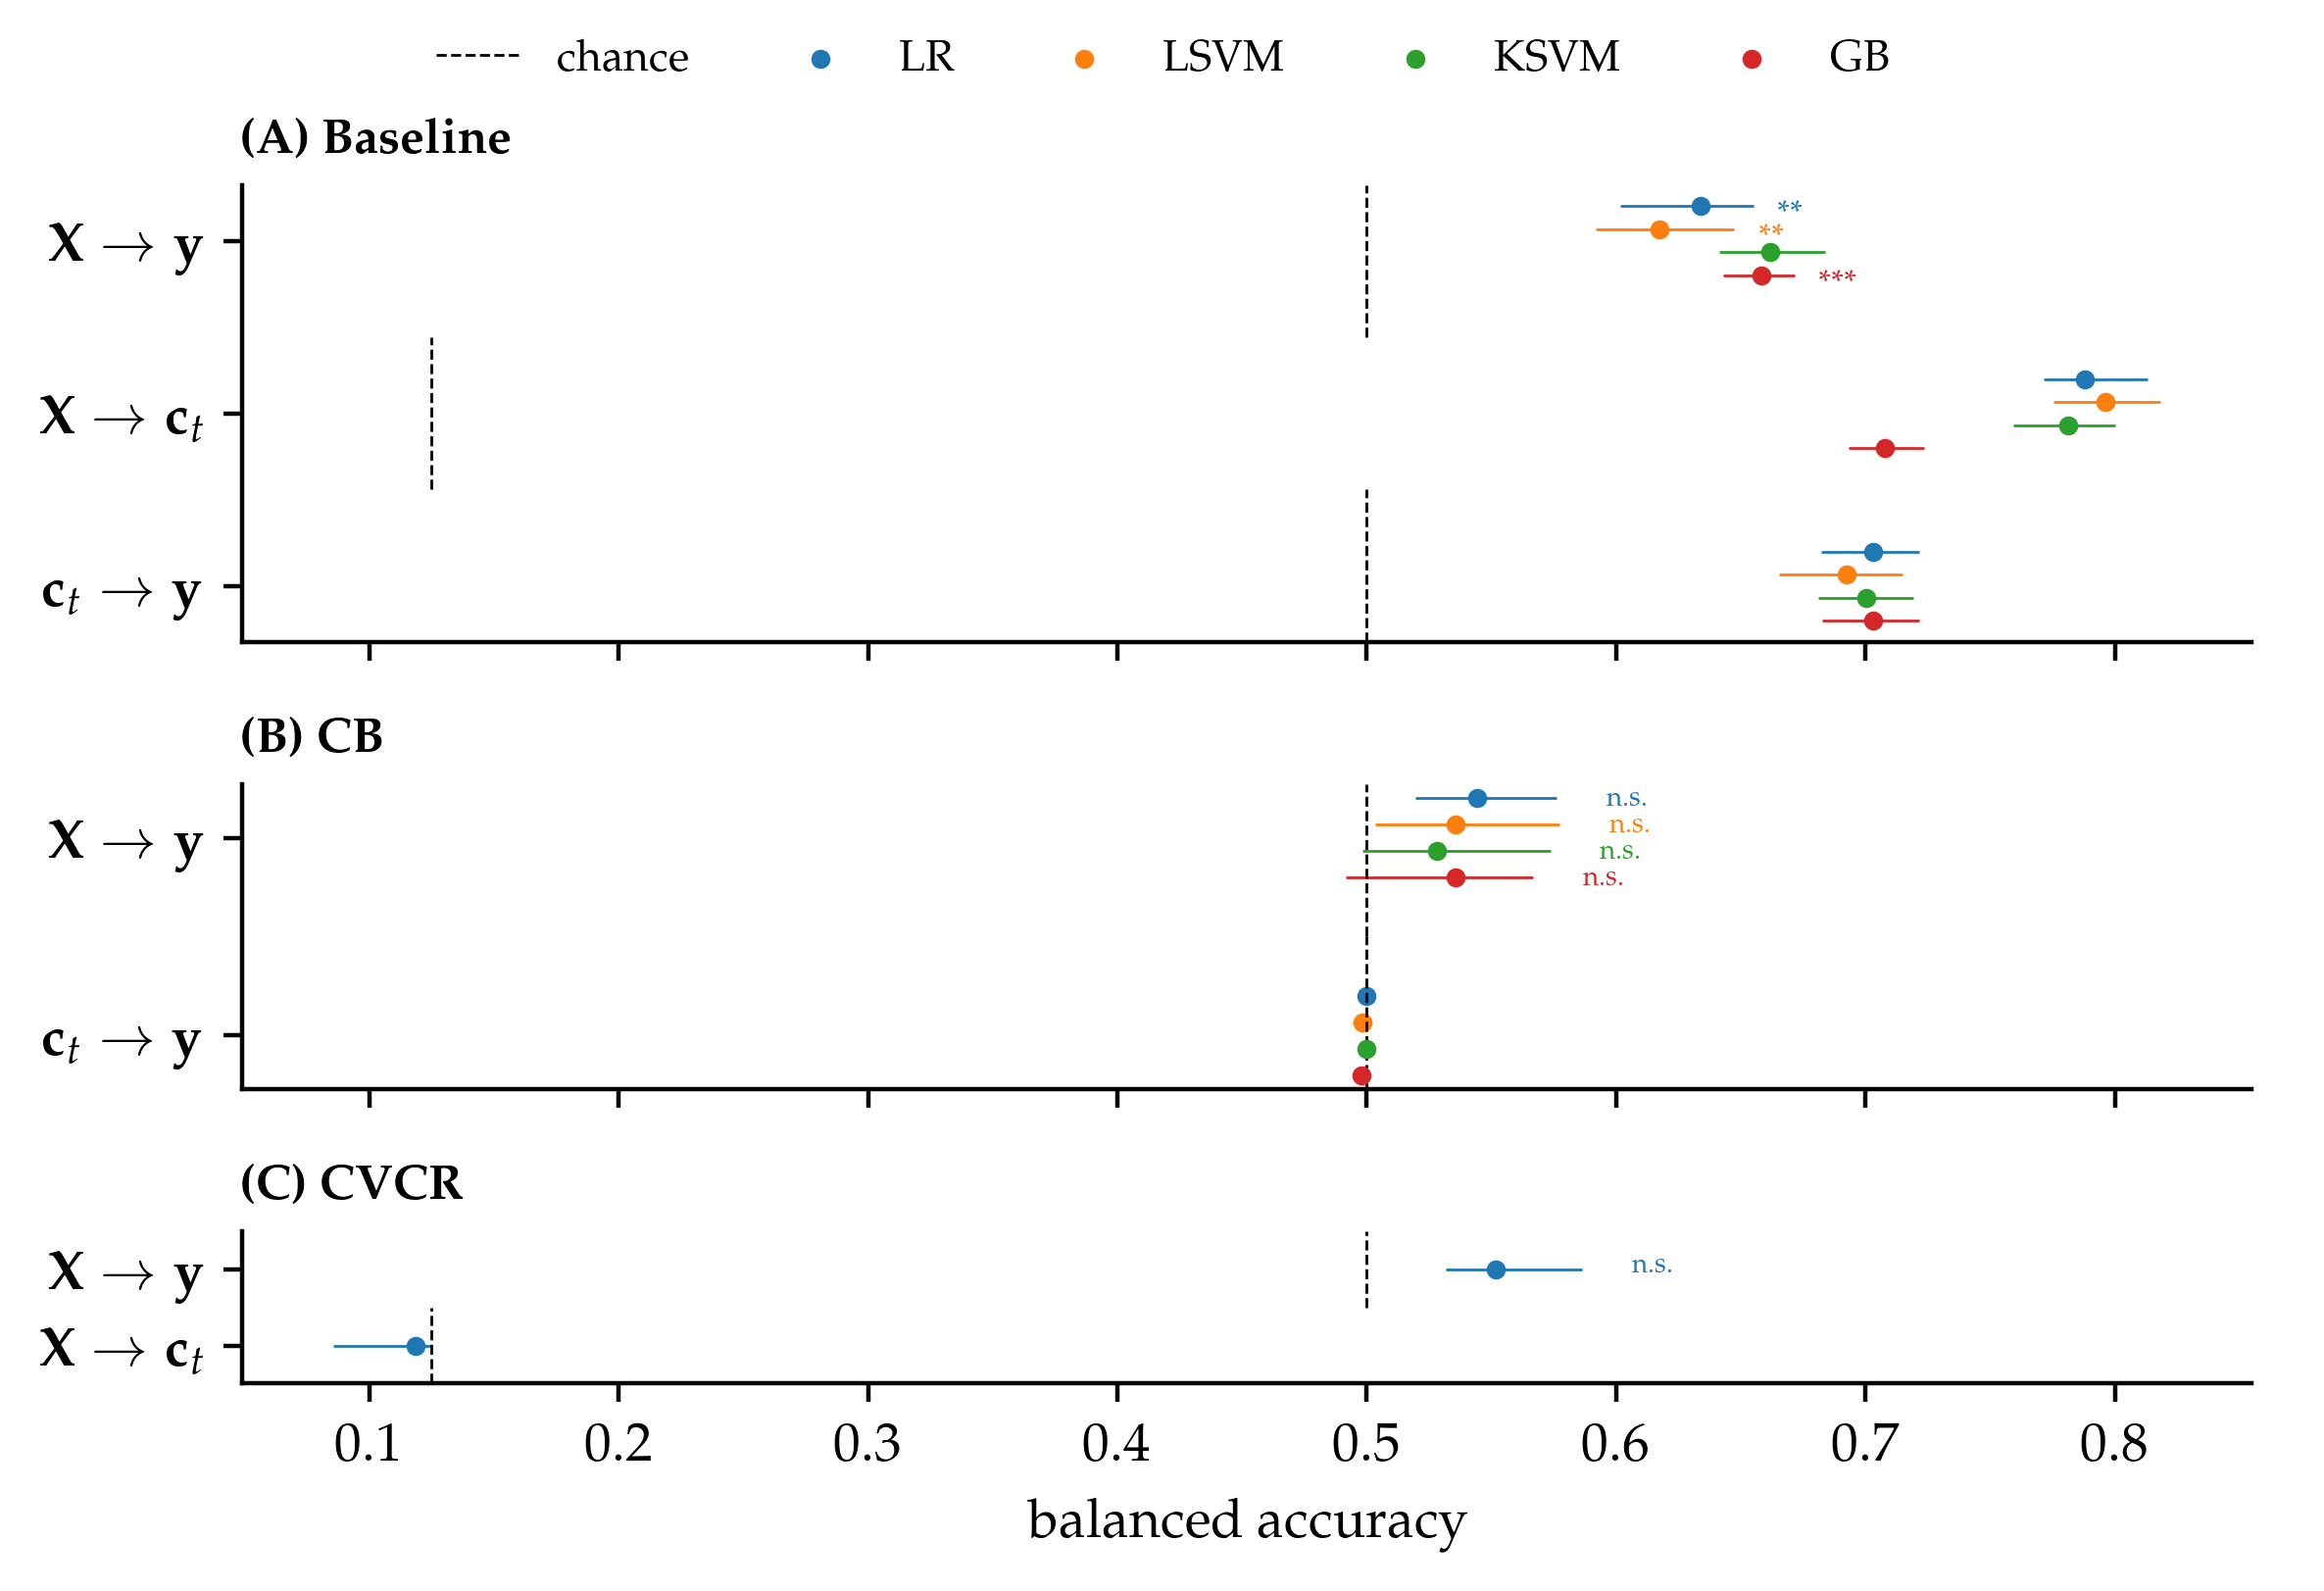

In [20]:
t1w1 = pd.read_csv("t1w-1.csv")
t1w1 = t1w1.rename(columns={
    "ba_mean":"ba-mean",
    "ba_ci_low" : "ba-ci-low",
    "ba_ci_high" : "ba-ci-high", 
    "ba_pvalue" : "ba-pvalue"
})

fig, ax = plt.subplots(ncols=1, nrows=3, dpi=400, sharex=True, sharey=False, figsize=(6.3,4.3),\
                      gridspec_kw={'height_ratios': [3,2, 1]})


ax[0].set_title(r"\textbf{(A) Baseline}", fontsize=9, loc="left")
ax[1].set_title(r"\textbf{(B) CB}", fontsize=9, loc="left")
ax[2].set_title(r"\textbf{(C) CVCR}", fontsize=9, loc="left")
#ax[3,0].set_title(r"\textbf{(D) CB$_s$ + CVCR$_t$}", fontsize=9, loc="left")


for i, technique in enumerate(["baseline", "cb", "cvcr"]):
    setting = "id"
        
    dfx = t1w1.query("technique == '{}' and setting == '{}'".format(technique, setting))
    dfx = dfx.query("model != 'GaussianNB'")

    if technique == "baseline":
        chance = [0.5, 0.125, 0.5]
        dodge = 0.4
        yticks = [
            r"$\mathbf{X} \to \mathbf{y}$", 
            r"$\mathbf{X} \to \mathbf{c}_t$", 
            r"$\mathbf{c}_t \to \mathbf{y}$"
        ]
    elif technique == "cvcr":
        chance = [0.125, 0.5]
        dodge = 0
        dfx = dfx.query("io == 'X-y' or io == 'X-c'")
        yticks = [
            r"$\mathbf{X} \to \mathbf{y}$", 
            r"$\mathbf{X} \to \mathbf{c}_t$"
        ]
        ax[i].set_ylim([-1, 3])
    elif technique == "cb":
        chance = [0.5, 0.5]
        dodge = 0.4
        dfx = dfx.query("io == 'X-y' or io == 'c-y'")
        yticks = [
            r"$\mathbf{X} \to \mathbf{y}$", 
            r"$\mathbf{c}_t \to \mathbf{y}$"
        ] 

    a = sns.pointplot(y="io", x="ba-mean", hue="model", join=False, data=dfx, \
                            dodge=dodge, scale=posz, errwidth=0.85, ax=ax[i], ci=None, palette=c)

    a.legend_.remove()

    ax[i].set_yticklabels(yticks)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")


    n_models = len(dfx["model"].unique())
    dodge_ = np.linspace(0, dodge, n_models) - np.linspace(0, dodge, n_models).mean() 

    n_io = len(dfx.io.unique())
    if chance:
        for z, ch in enumerate(chance):
            ax[i].axvline(x=ch, ymin=z/len(chance),ymax=(z+1)/(len(chance)), label="chance", \
                            c='k', ls='--', lw=0.5)

    # Add errorbars and significance stars 
    for k, io in enumerate(dfx["io"].unique()):
        for m, model in enumerate(dfx["model"].unique()):
            if model != "LogisticRegression" and technique == "cvcr":
                continue
            dfxx = dfx.query("model == '{}' and {} == '{}'".format(model, "io", io))
            test_score = dfxx["ba-mean"].values[0]
            ci_low = dfxx["ba-ci-low"].values[0]
            ci_high = dfxx["ba-ci-high"].values[0]
            err = [[abs(test_score - ci_low)], [abs(test_score-ci_high)]]
            ax[i].errorbar(test_score, k+dodge_[m], xerr=err, c=c[m], elinewidth=0.5)
            
            pvalue = dfxx["ba-pvalue"].values[0]
            if (not np.isnan(pvalue)) and (io == 'X-y'):
                ast = return_asterisks(pvalue)
                if ast == "n.s.":
                    ax[i].text(ci_high+0.02, k+dodge_[m]+0.04, r"{}".format(ast), c=c[m], fontsize=5)
                else:
                    ax[i].text(ci_high+0.01, k+dodge_[m]+0.095, r"{}".format(ast), c=c[m], fontsize=6)



fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel("balanced accuracy")

handles, _ = ax[i].get_legend_handles_labels()
handles = [handles[i] for i in len(chance)-1 + np.arange(len(dfx["model"].unique())+1)]
fig.legend(handles, ["chance", "LR", "LSVM", "KSVM", "GB"], fontsize=8, frameon=False, loc="upper center",ncol=5)

        
fig.tight_layout()
sns.despine()

plt.subplots_adjust(top=0.9)
plt.show()

## 2.3 T1w males

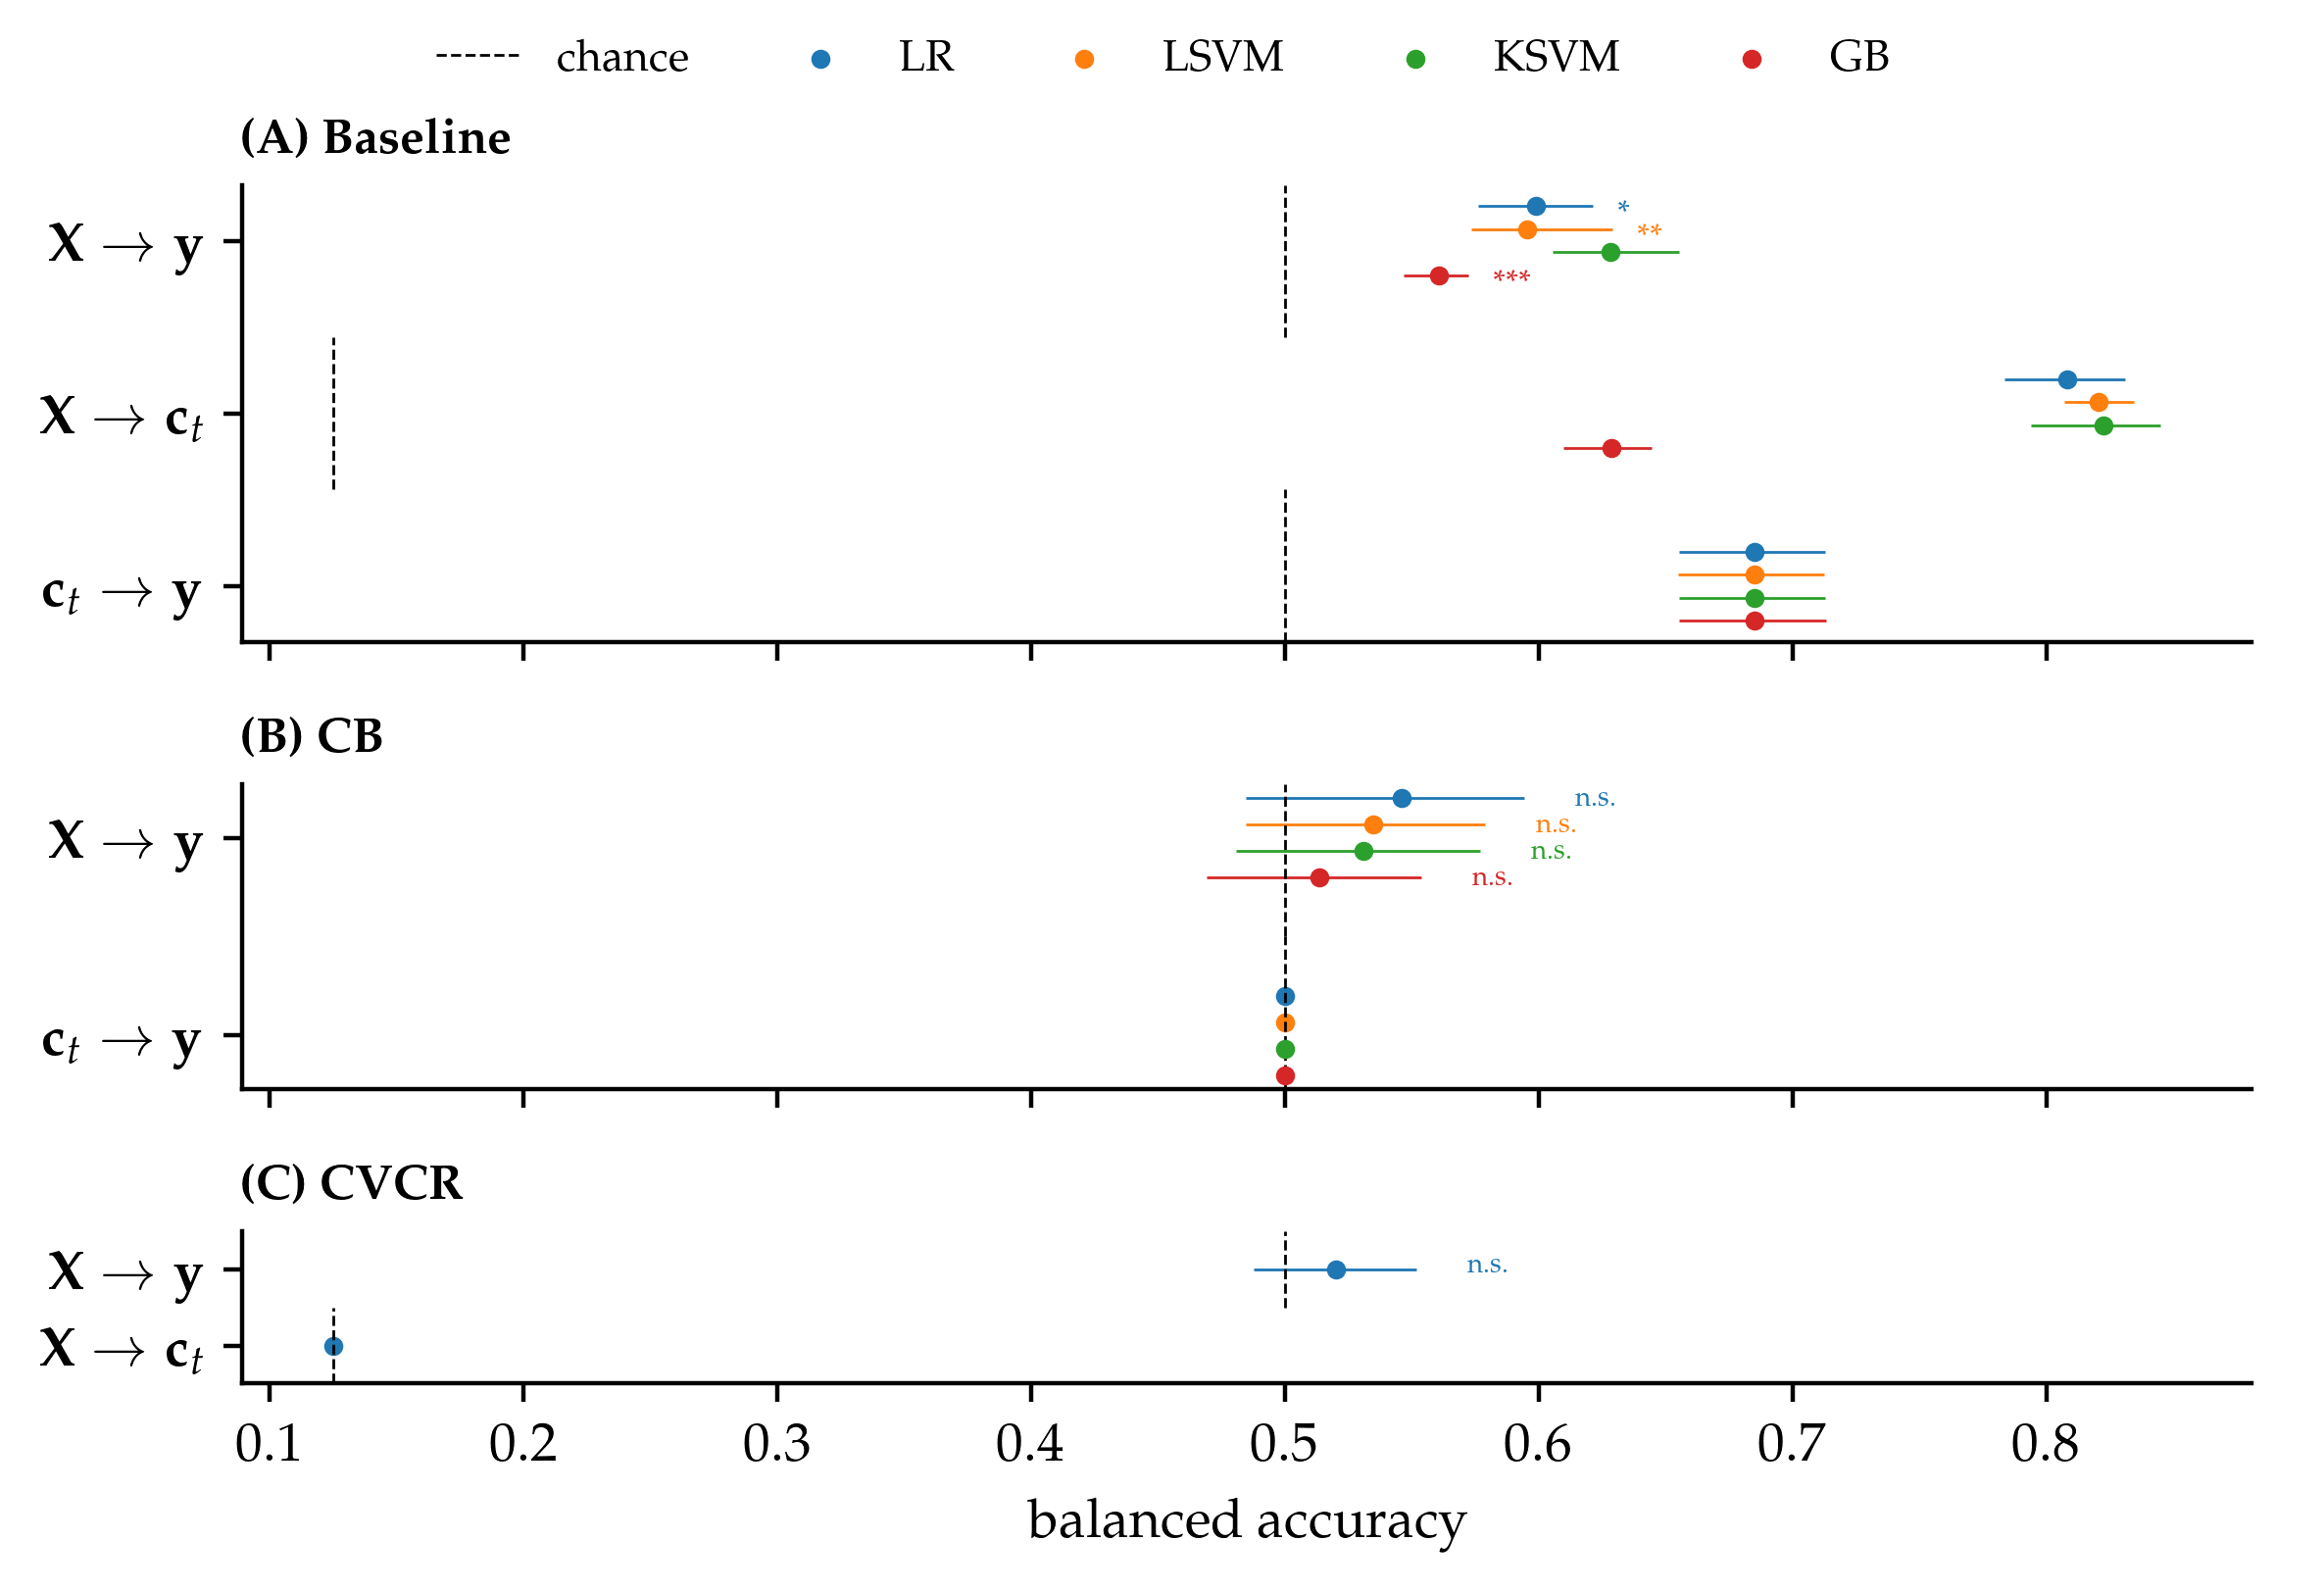

In [21]:
t1w0 = pd.read_csv("t1w-0.csv")
t1w0 = t1w0.rename(columns={
    "ba_mean":"ba-mean",
    "ba_ci_low" : "ba-ci-low",
    "ba_ci_high" : "ba-ci-high", 
    "ba_pvalue" : "ba-pvalue"
})

fig, ax = plt.subplots(ncols=1, nrows=3, dpi=400, sharex=True, sharey=False, figsize=(6.3,4.3),\
                      gridspec_kw={'height_ratios': [3,2, 1]})


ax[0].set_title(r"\textbf{(A) Baseline}", fontsize=9, loc="left")
ax[1].set_title(r"\textbf{(B) CB}", fontsize=9, loc="left")
ax[2].set_title(r"\textbf{(C) CVCR}", fontsize=9, loc="left")
#ax[3,0].set_title(r"\textbf{(D) CB$_s$ + CVCR$_t$}", fontsize=9, loc="left")


for i, technique in enumerate(["baseline", "cb", "cvcr"]):
    setting = "id"
        
    dfx = t1w0.query("technique == '{}' and setting == '{}'".format(technique, setting))
    dfx = dfx.query("model != 'GaussianNB'")

    if technique == "baseline":
        chance = [0.5, 0.125, 0.5]
        dodge = 0.4
        yticks = [
            r"$\mathbf{X} \to \mathbf{y}$", 
            r"$\mathbf{X} \to \mathbf{c}_t$", 
            r"$\mathbf{c}_t \to \mathbf{y}$"
        ]
    elif technique == "cvcr":
        chance = [0.125, 0.5]
        dodge = 0
        dfx = dfx.query("io == 'X-y' or io == 'X-c'")
        yticks = [
            r"$\mathbf{X} \to \mathbf{y}$", 
            r"$\mathbf{X} \to \mathbf{c}_t$"
        ]
        ax[i].set_ylim([-1, 3])
    elif technique == "cb":
        chance = [0.5, 0.5]
        dodge = 0.4
        dfx = dfx.query("io == 'X-y' or io == 'c-y'")
        yticks = [
            r"$\mathbf{X} \to \mathbf{y}$", 
            r"$\mathbf{c}_t \to \mathbf{y}$"
        ] 

    a = sns.pointplot(y="io", x="ba-mean", hue="model", join=False, data=dfx, \
                            dodge=dodge, scale=posz, errwidth=0.85, ax=ax[i], ci=None, palette=c)

    a.legend_.remove()

    ax[i].set_yticklabels(yticks)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")


    n_models = len(dfx["model"].unique())
    dodge_ = np.linspace(0, dodge, n_models) - np.linspace(0, dodge, n_models).mean() 

    n_io = len(dfx.io.unique())
    if chance:
        for z, ch in enumerate(chance):
            ax[i].axvline(x=ch, ymin=z/len(chance),ymax=(z+1)/(len(chance)), label="chance", \
                            c='k', ls='--', lw=0.5)

    # Add errorbars and significance stars 
    for k, io in enumerate(dfx["io"].unique()):
        for m, model in enumerate(dfx["model"].unique()):
            if model != "LogisticRegression" and technique == "cvcr":
                continue
            dfxx = dfx.query("model == '{}' and {} == '{}'".format(model, "io", io))
            test_score = dfxx["ba-mean"].values[0]
            ci_low = dfxx["ba-ci-low"].values[0]
            ci_high = dfxx["ba-ci-high"].values[0]
            err = [[abs(test_score - ci_low)], [abs(test_score-ci_high)]]
            ax[i].errorbar(test_score, k+dodge_[m], xerr=err, c=c[m], elinewidth=0.5)
            
            pvalue = dfxx["ba-pvalue"].values[0]
            if (not np.isnan(pvalue)) and (io == 'X-y'):
                ast = return_asterisks(pvalue)
                if ast == "n.s.":
                    ax[i].text(ci_high+0.02, k+dodge_[m]+0.04, r"{}".format(ast), c=c[m], fontsize=5)
                else:
                    ax[i].text(ci_high+0.01, k+dodge_[m]+0.095, r"{}".format(ast), c=c[m], fontsize=6)



fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel("balanced accuracy")

handles, _ = ax[i].get_legend_handles_labels()
handles = [handles[i] for i in len(chance)-1 + np.arange(len(dfx["model"].unique())+1)]
fig.legend(handles, ["chance", "LR", "LSVM", "KSVM", "GB"], fontsize=8, frameon=False, loc="upper center",ncol=5)

        
fig.tight_layout()
sns.despine()

plt.subplots_adjust(top=0.9)
plt.show()

# 3. DTI

In [22]:
fab = pd.read_csv("dti-FA-both.csv").assign(sex="both")

fab = fab.rename(columns={
    "ba_mean":"ba-mean",
    "ba_ci_low" : "ba-ci-low",
    "ba_ci_high" : "ba-ci-high", 
    "ba_pvalue" : "ba-pvalue"
})

/Users/evertdeman/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


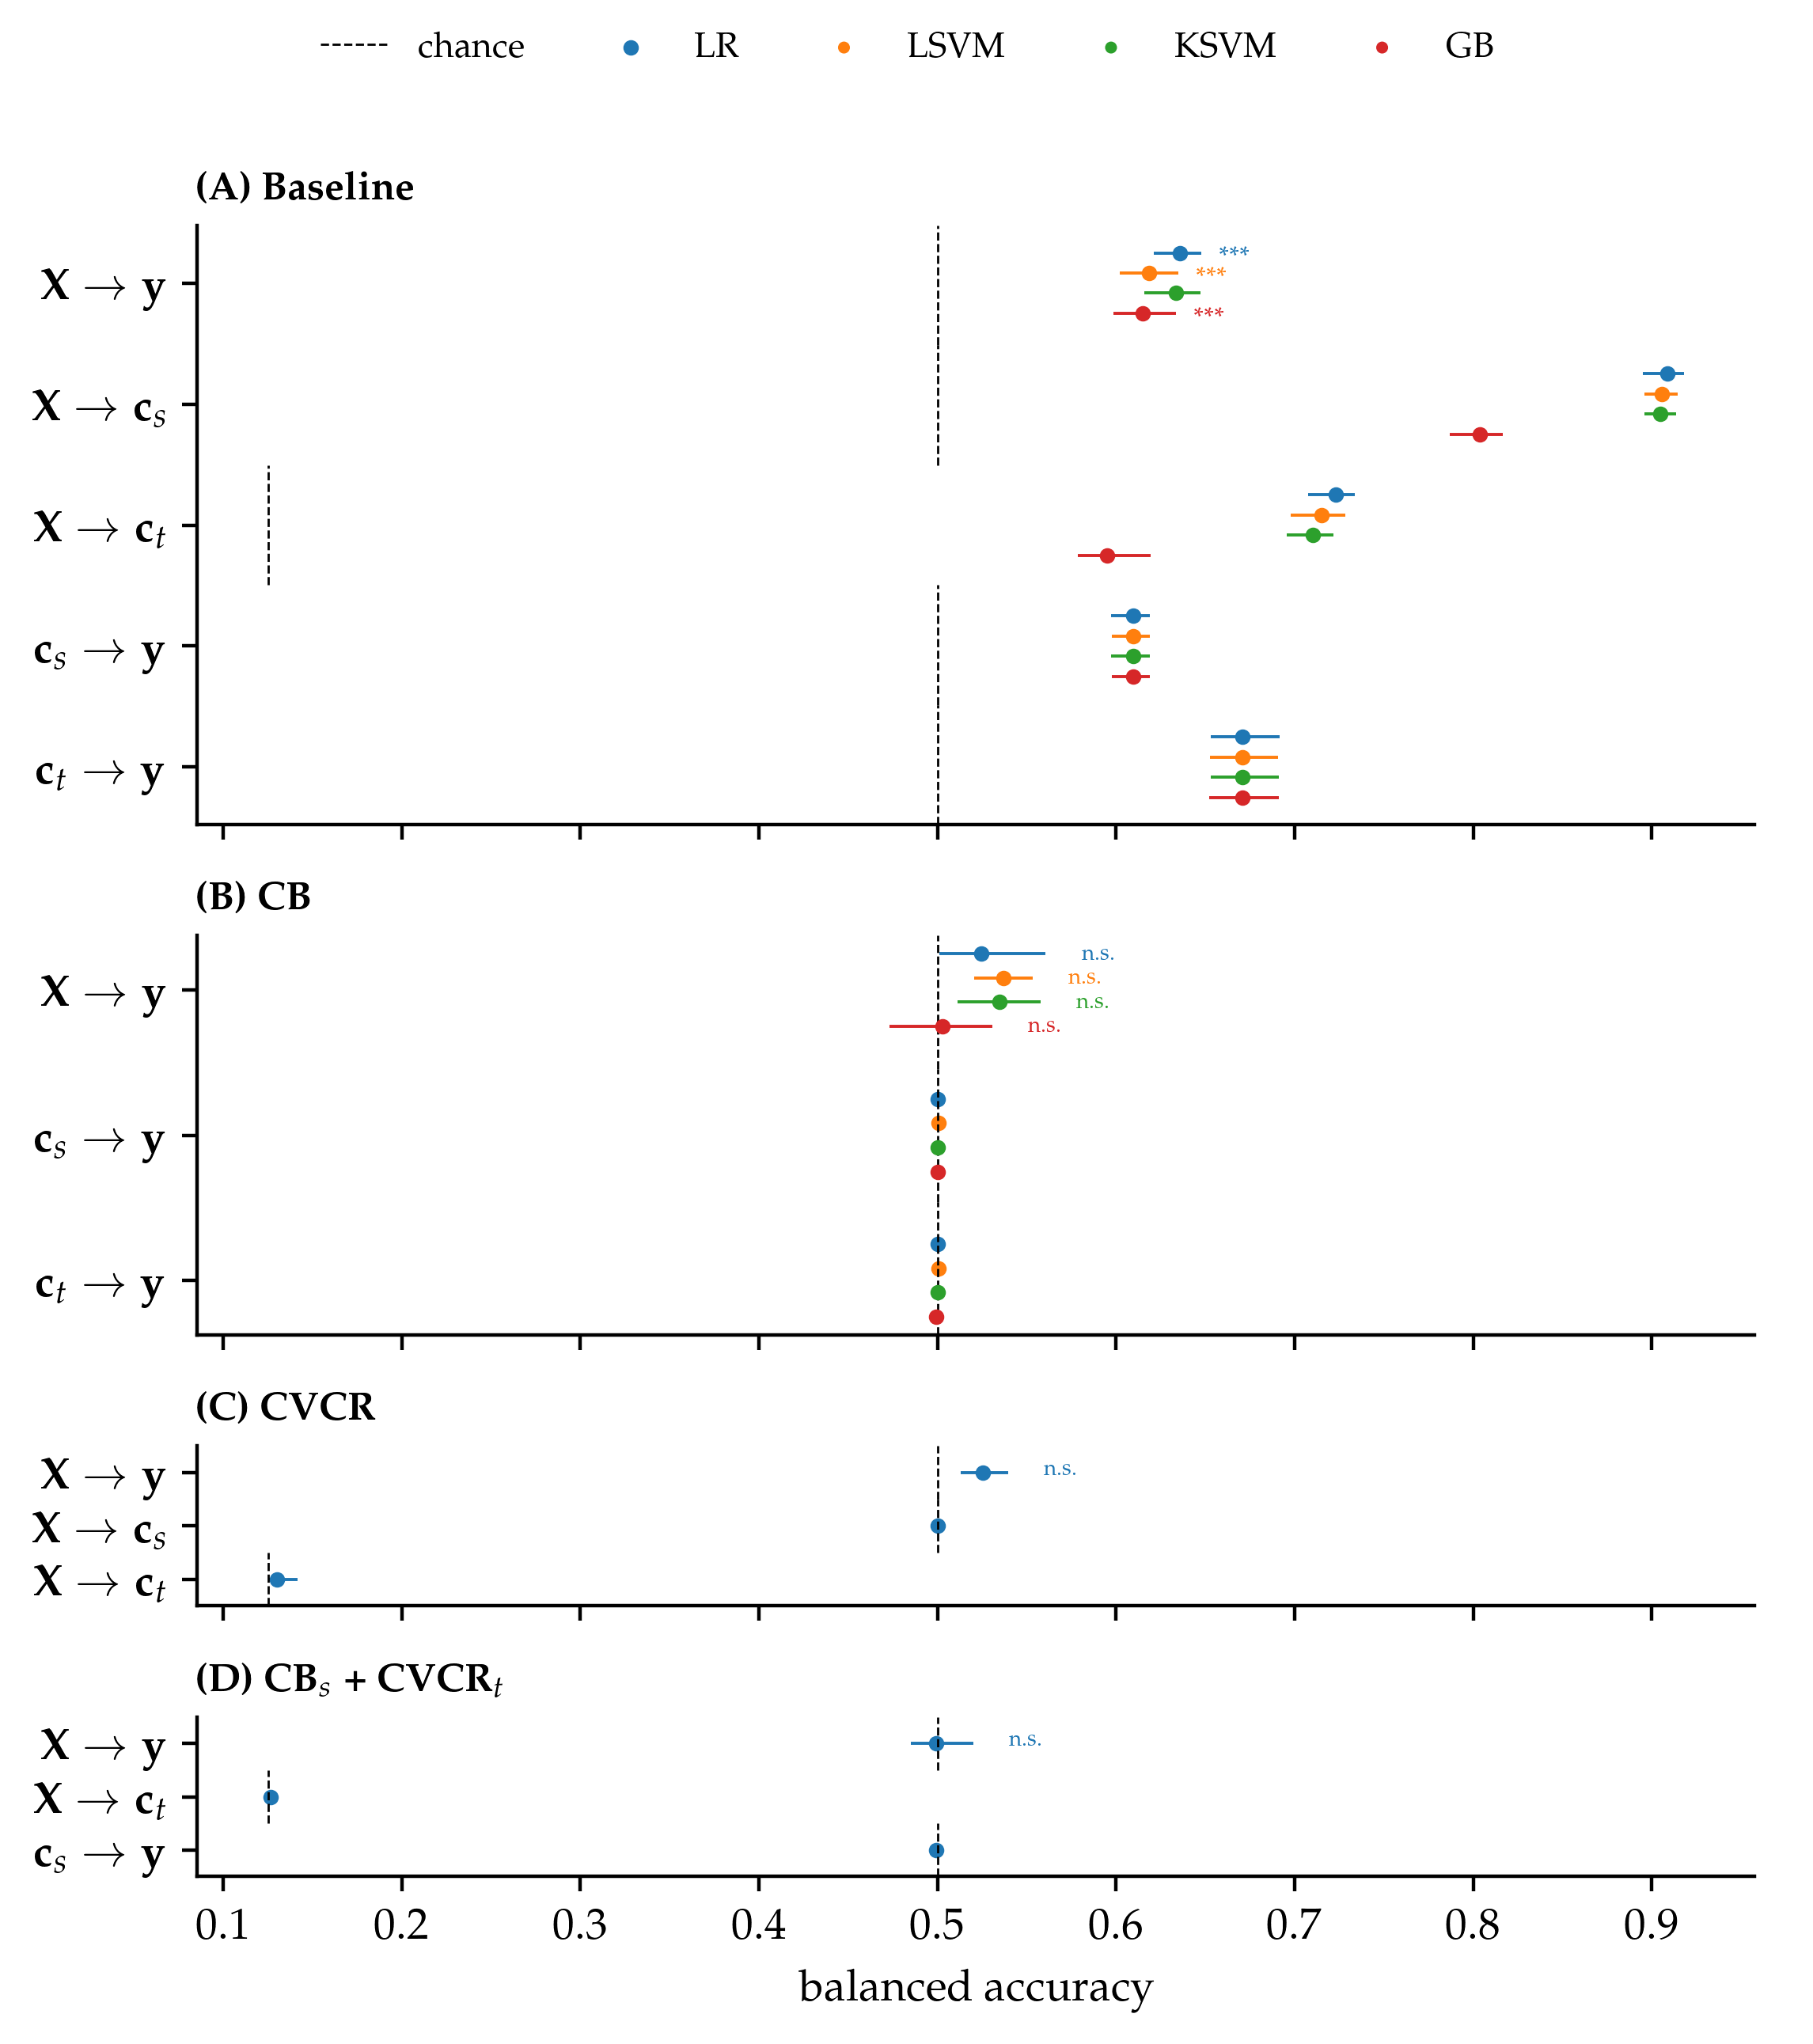

In [23]:
df = fab

c = sns.color_palette()
dodge = 0.3
chance = [0.5, 0.5, 0.125, 0.5, 0.5]

yticks = [
    r"$\mathbf{X} \to \mathbf{y}$", 
    r"$\mathbf{X} \to \mathbf{c}_s$", 
    r"$\mathbf{X} \to \mathbf{c}_t$", 
    r"$\mathbf{c}_s \to \mathbf{y}$", 
    r"$\mathbf{c}_t \to \mathbf{y}$"
]


fig, ax = plt.subplots(ncols=1, nrows=4, dpi=400, sharex=True, sharey=False, figsize=(fig_width,6.7),\
                      gridspec_kw={'height_ratios': [3,2, 0.8, 0.8]})



for i, technique in enumerate(["baseline", "cb", "cvcr", "cbcvcr"]):
    setting = "id"
        
    dfx = df.query("technique == '{}' and setting == '{}'".format(technique, setting))
    dfx = dfx.query("model != 'GaussianNB'")

        
    if technique == "baseline":
        chance = [0.5, 0.5, 0.125, 0.5, 0.5]
        dodge = 0.5
        yticks = [
            r"$\mathbf{X} \to \mathbf{y}$", 
            r"$\mathbf{X} \to \mathbf{c}_s$", 
            r"$\mathbf{X} \to \mathbf{c}_t$", 
            r"$\mathbf{c}_s \to \mathbf{y}$",
            r"$\mathbf{c}_t \to \mathbf{y}$"
        ]
    elif technique == "cb":
        chance = [0.5, 0.5, 0.5]
        dodge = 0.5
        dfx = dfx.query("(io == 'X-y' or io == 'c-y') or io == 's-y'")
        yticks = [
            r"$\mathbf{X} \to \mathbf{y}$", 
            r"$\mathbf{c}_s \to \mathbf{y}$",
            r"$\mathbf{c}_t \to \mathbf{y}$"
        ]
    elif technique == "cvcr":
        chance = [0.125, 0.5, 0.5]
        dodge = 0
        dfx = dfx.query("(io == 'X-y' or io == 'X-c') or io == 'X-s'")
        yticks = [
            r"$\mathbf{X} \to \mathbf{y}$", 
            r"$\mathbf{X} \to \mathbf{c}_s$",
            r"$\mathbf{X} \to \mathbf{c}_t$"
        ]
        ax[i].set_ylim([-1, 3])
    elif technique == "cbcvcr":
        dfx = dfx.query("(io == 'X-y' or io == 'X-c') or io == 's-y'")
        chance = [0.5, 0.125, 0.5]
        dodge = 0
        yticks = [
            r"$\mathbf{X} \to \mathbf{y}$", 
            r"$\mathbf{X} \to \mathbf{c}_t$", 
            r"$\mathbf{c}_s \to \mathbf{y}$"
        ]
        ax[i].set_ylim([-1, 3])
        

    a = sns.pointplot(y="io", x="ba-mean", hue="model", join=False, data=dfx, \
                            dodge=dodge, scale=posz, errwidth=0.85, ax=ax[i], ci=None, palette=c)
    a.legend_.remove()


    ax[i].set_yticklabels(yticks)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")


    n_models = len(dfx["model"].unique())
    dodge_ = np.linspace(0, dodge, n_models) - np.linspace(0, dodge, n_models).mean() 

    n_io = len(dfx.io.unique())
    if chance:
        for z, ch in enumerate(chance):
            ax[i].axvline(x=ch, ymin=z/len(chance),ymax=(z+1)/(len(chance)), label="chance", \
                            c='k', ls='--', lw=0.5)

    # Add errorbars and significance stars 
    for k, io in enumerate(dfx["io"].unique()):
        for m, model in enumerate(dfx["model"].unique()):
            if model != "LogisticRegression" and (technique == "cvcr" or technique == "cvcrcb"):
                continue
            dfxx = dfx.query("model == '{}' and {} == '{}'".format(model, "io", io))
            

            test_score = dfxx["ba-mean"].values[0]
            ci_low = dfxx["ba-ci-low"].values[0]
            ci_high = dfxx["ba-ci-high"].values[0]

            err = [[abs(test_score - ci_low)], [abs(test_score-ci_high)]]
            ax[i].errorbar(test_score, k+dodge_[m], xerr=err, c=c[m], elinewidth=lisz)
            
            pvalue = dfxx["ba-pvalue"].values[0]
            if (not np.isnan(pvalue)) and (io == 'X-y'):
                ast = return_asterisks(pvalue)
                if ast == "n.s.":
                    ax[i].text(ci_high+0.02, k+dodge_[m]+0.04, r"{}".format(ast), c=c[m], fontsize=5)
                else:
                    ax[i].text(ci_high+0.01, k+dodge_[m]+0.095, r"{}".format(ast), c=c[m], fontsize=6)


ax[0].set_title(r"\textbf{(A) Baseline}", fontsize=9, loc="left")
ax[1].set_title(r"\textbf{(B) CB}", fontsize=9, loc="left")
ax[2].set_title(r"\textbf{(C) CVCR}", fontsize=9, loc="left")
ax[3].set_title(r"\textbf{(D) CB$_s$ + CVCR$_t$}", fontsize=9, loc="left")


fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel("balanced accuracy")

handles, _ = ax[i].get_legend_handles_labels()
handles = [handles[i] for i in len(chance)-1 + np.arange(len(dfx["model"].unique())+1)]
fig.legend(handles, ["chance", "LR", "LSVM", "KSVM", "GB"], fontsize=8, frameon=False, loc="upper center", ncol=5)

        
fig.tight_layout()
sns.despine()

plt.subplots_adjust(top=0.9)
plt.show()

## 3.2 DTI females

In [24]:
fa1 = pd.read_csv("dti-FA-females.csv")
fa1 = fa1.rename(columns={
    "ba_mean":"ba-mean",
    "ba_ci_low" : "ba-ci-low",
    "ba_ci_high" : "ba-ci-high", 
    "ba_pvalue" : "ba-pvalue"
})
c = sns.color_palette()
dodge = 0.3
chance = [0.125, 0.5]
yticks = yticks = [
    r"$\mathbf{X} \to \mathbf{y}$", 
    r"$\mathbf{X} \to \mathbf{c}_t$"
]

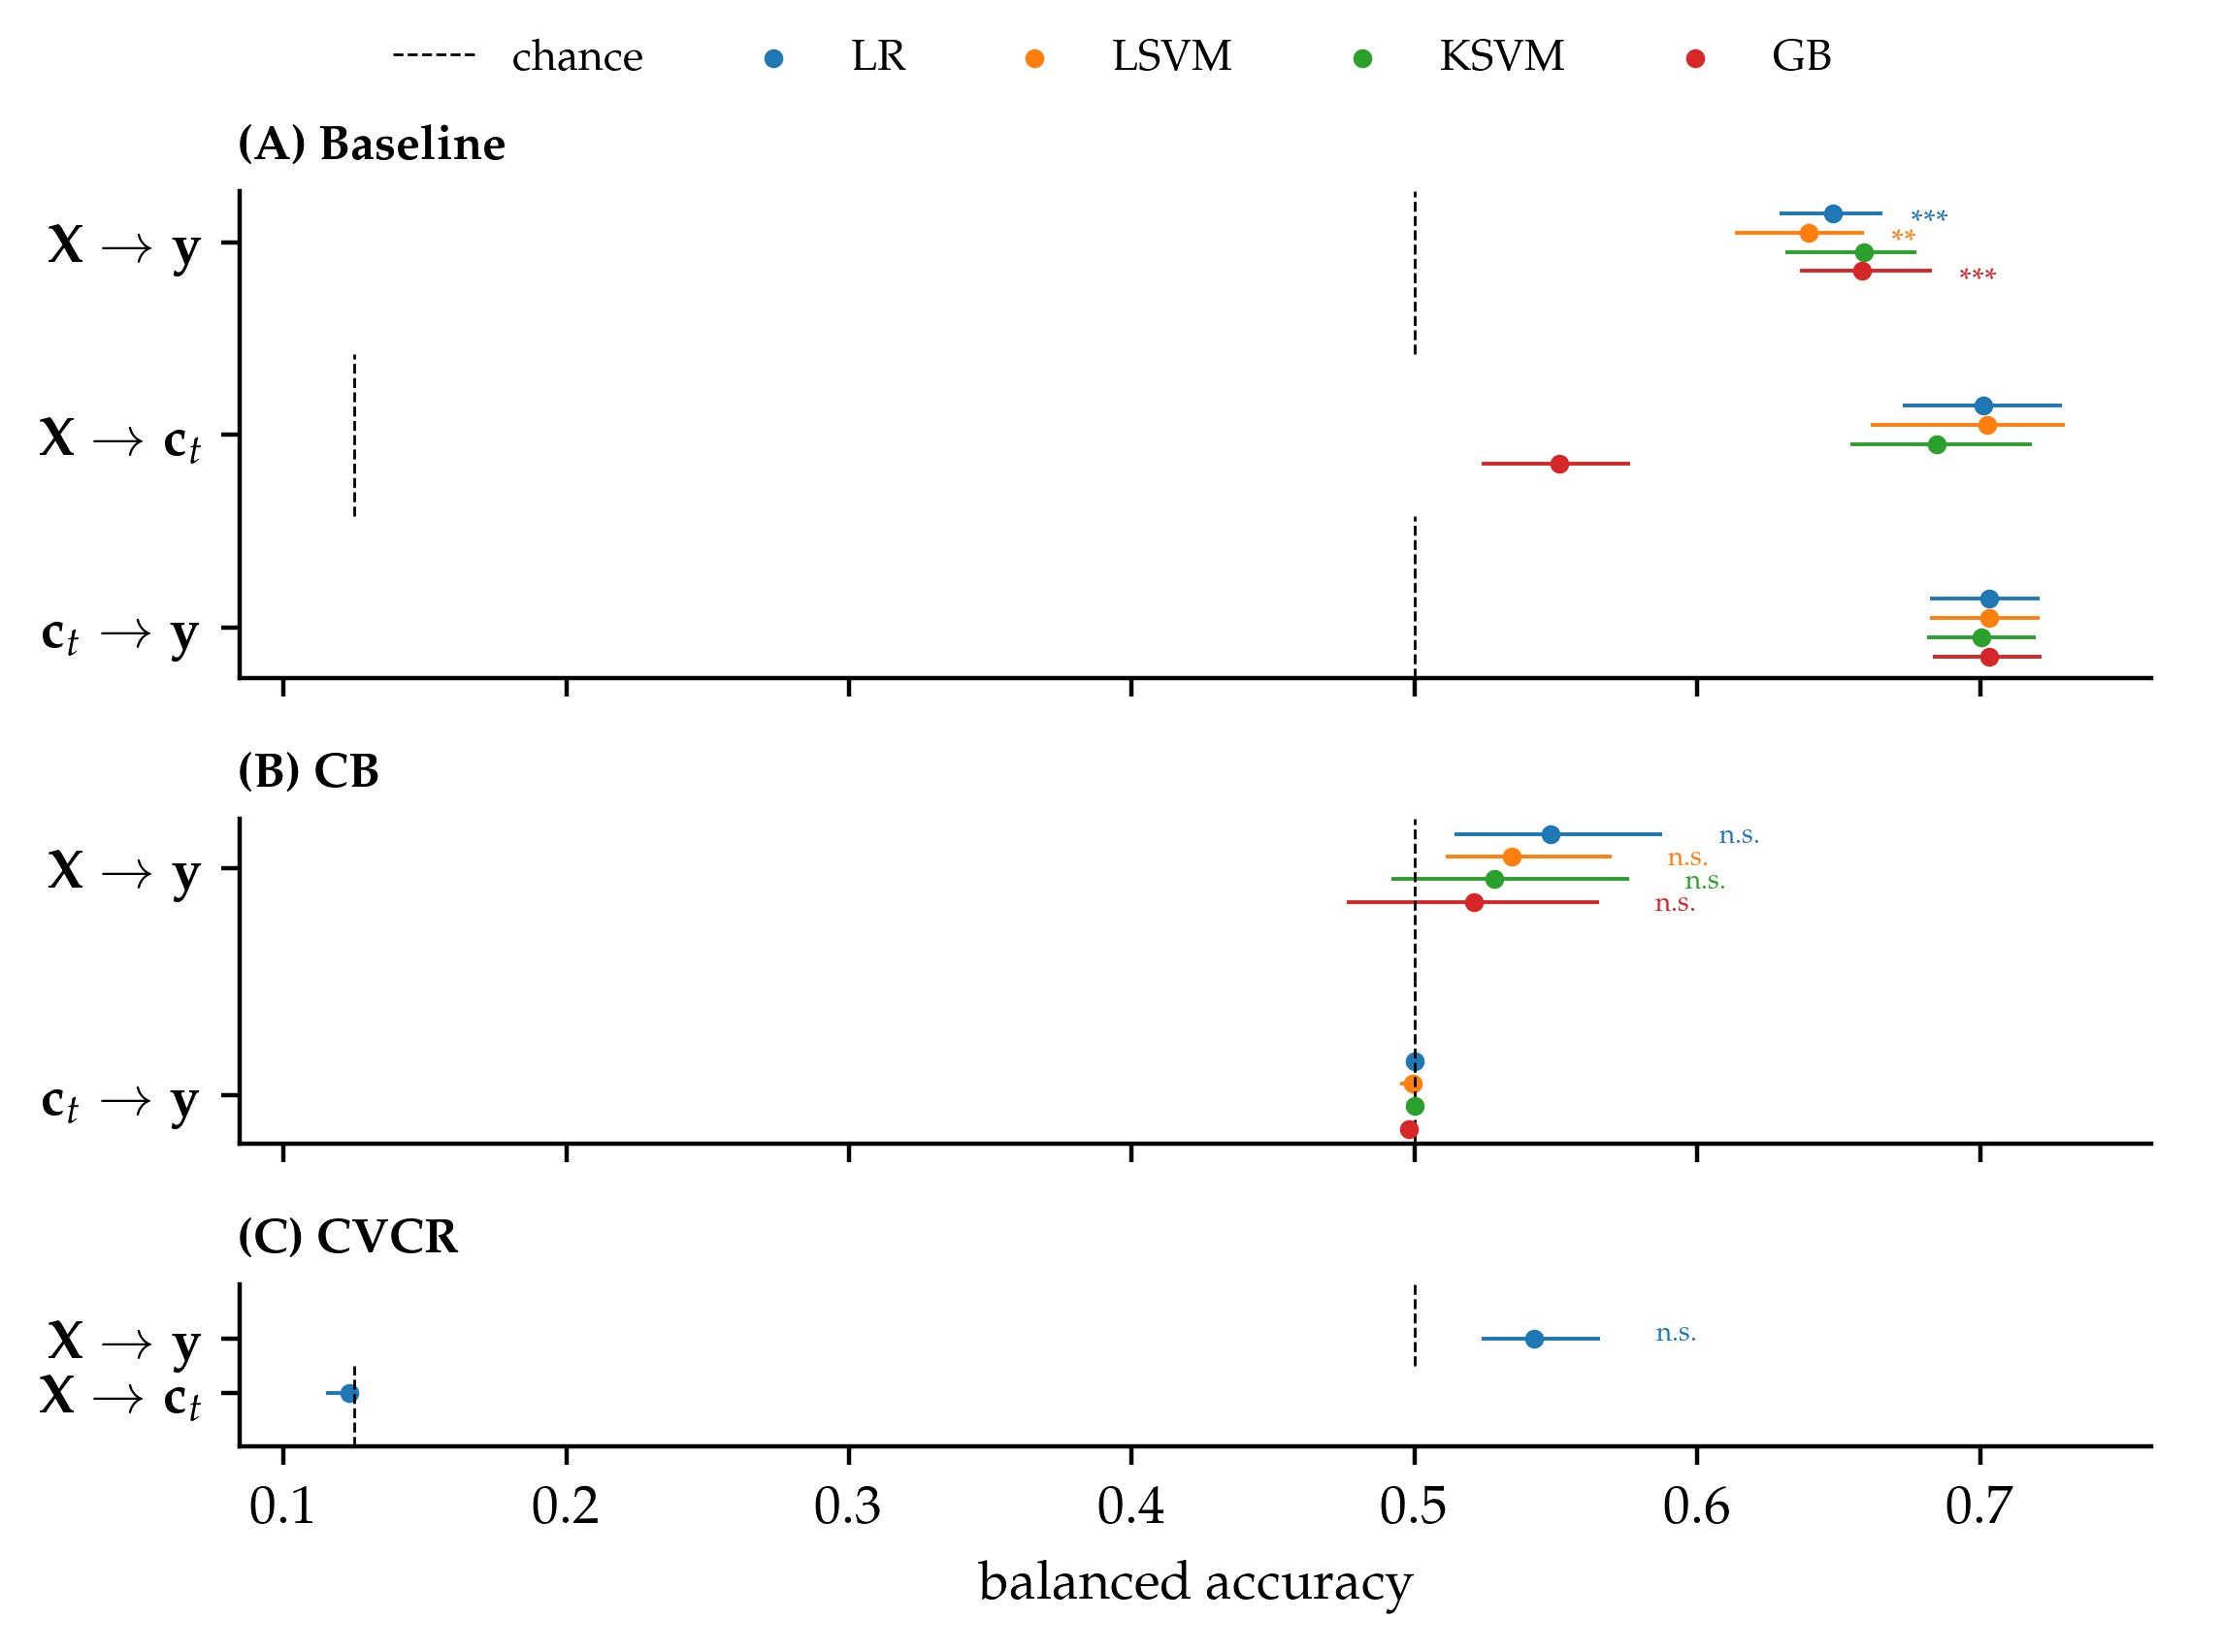

In [25]:
df = fa1
#df = df.query("io != 's-y'").query("io != 'c-y'")
c = sns.color_palette()
dodge = 0.3
chance = [0.125, 0.5]
yticks = yticks = [
    r"$\mathbf{X} \to \mathbf{y}$", 
    r"$\mathbf{X} \to \mathbf{c}_t$",
    r"$\mathbf{c}_t \to \mathbf{y}$"
]


fig, ax = plt.subplots(ncols=1, nrows=3, dpi=400, sharex=True, sharey=False, figsize=(fig_width,4.5),\
                      gridspec_kw={'height_ratios': [3, 2, 1]})


ax[0].set_title(r"\textbf{(A) Baseline}", fontsize=9, loc="left")
ax[1].set_title(r"\textbf{(B) CB}", fontsize=9, loc="left")
ax[2].set_title(r"\textbf{(C) CVCR}", fontsize=9, loc="left")
#ax[3,0].set_title(r"\textbf{(D) CB$_s$ + CVCR$_t$}", fontsize=9, loc="left")


for i, technique in enumerate(["baseline", "cb", "cvcr"]):
    setting = "id"
        
    dfx = df.query("technique == '{}' and setting == '{}'".format(technique, setting))
    dfx = dfx.query("model != 'GaussianNB'")


    if technique == "cb":
        dfx = dfx.query("io != 'X-s'").query("io != 'X-c'")
    elif technique == "cvcr":
        dfx = dfx.query("io != 's-y'").query("io != 'c-y'")
        dodge = 0


    a = sns.pointplot(y="io", x="ba-mean", hue="model", join=False, data=dfx, \
                            dodge=dodge, scale=posz, errwidth=0.85, ax=ax[i], ci=None, palette=c)

    a.legend_.remove()

    if technique == "baseline":
        ax[i].set_yticklabels([
            r"$\mathbf{X} \to \mathbf{y}$",
            r"$\mathbf{X} \to \mathbf{c}_t$",
            r"$\mathbf{c}_t \to \mathbf{y}$"
        ])
        chance = [0.5, 0.125, 0.5]
    elif technique == "cb":
        ax[i].set_yticklabels([r"$\mathbf{X} \to \mathbf{y}$", 
                               r"$\mathbf{c}_t \to \mathbf{y}$"])
        chance = [0.5, 0.5]
    elif technique == "cvcr":
        ax[i].set_yticklabels([r"$\mathbf{X} \to \mathbf{y}$", 
                               r"$\mathbf{X} \to \mathbf{c}_t$"])
        chance = [0.125, 0.5]
        dodge = 0
        ax[i].set_ylim([2, -1])

    ax[i].set_xlabel("")
    ax[i].set_ylabel("")


    n_models = len(dfx["model"].unique())
    dodge_ = np.linspace(0, dodge, n_models) - np.linspace(0, dodge, n_models).mean() 

    n_io = len(dfx.io.unique())
    if chance:
        for z, ch in enumerate(chance):
            ax[i].axvline(x=ch, ymin=z/len(chance),ymax=(z+1)/(len(chance)), label="chance", \
                            c='k', ls='--', lw=0.5)

    # Add errorbars and significance stars 
    for k, io in enumerate(dfx["io"].unique()):
        for m, model in enumerate(dfx["model"].unique()):
            if model != "LogisticRegression" and technique == "cvcr":
                continue
            dfxx = dfx.query("model == '{}' and {} == '{}'".format(model, "io", io))
            test_score = dfxx["ba-mean"].values[0]
            ci_low = dfxx["ba-ci-low"].values[0]
            ci_high = dfxx["ba-ci-high"].values[0]
            err = [[abs(test_score - ci_low)], [abs(test_score-ci_high)]]
            ax[i].errorbar(test_score, k+dodge_[m], xerr=err, c=c[m], elinewidth=lisz)
            
            pvalue = dfxx["ba-pvalue"].values[0]
            if (not np.isnan(pvalue)) and (io == 'X-y'):
                ast = return_asterisks(pvalue)
                if ast == "n.s.":
                    ax[i].text(ci_high+0.02, k+dodge_[m]+0.04, r"{}".format(ast), c=c[m], fontsize=5)
                else:
                    ax[i].text(ci_high+0.01, k+dodge_[m]+0.095, r"{}".format(ast), c=c[m], fontsize=6)



fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel("balanced accuracy")

handles, _ = ax[i].get_legend_handles_labels()
handles = [handles[i] for i in len(chance)-1 + np.arange(len(dfx["model"].unique())+1)]
fig.legend(handles, ["chance", "LR", "LSVM", "KSVM", "GB"], fontsize=8, frameon=False, loc="upper center",ncol=5)

        
fig.tight_layout()
sns.despine()

plt.subplots_adjust(top=0.9)
plt.show()

## 3.3 DTI males

In [26]:
fa0 = pd.read_csv("dti-FA-males.csv")
fa0 = fa0.rename(columns={
    "ba_mean":"ba-mean",
    "ba_ci_low" : "ba-ci-low",
    "ba_ci_high" : "ba-ci-high", 
    "ba_pvalue" : "ba-pvalue"
})
dodge = 0.3
chance = [0.125, 0.5]
yticks = yticks = [
    r"$\mathbf{X} \to \mathbf{y}$", 
    r"$\mathbf{X} \to \mathbf{c}_t$", 
    r"$\mathbf{c}_t \to \mathbf{y}$"
]

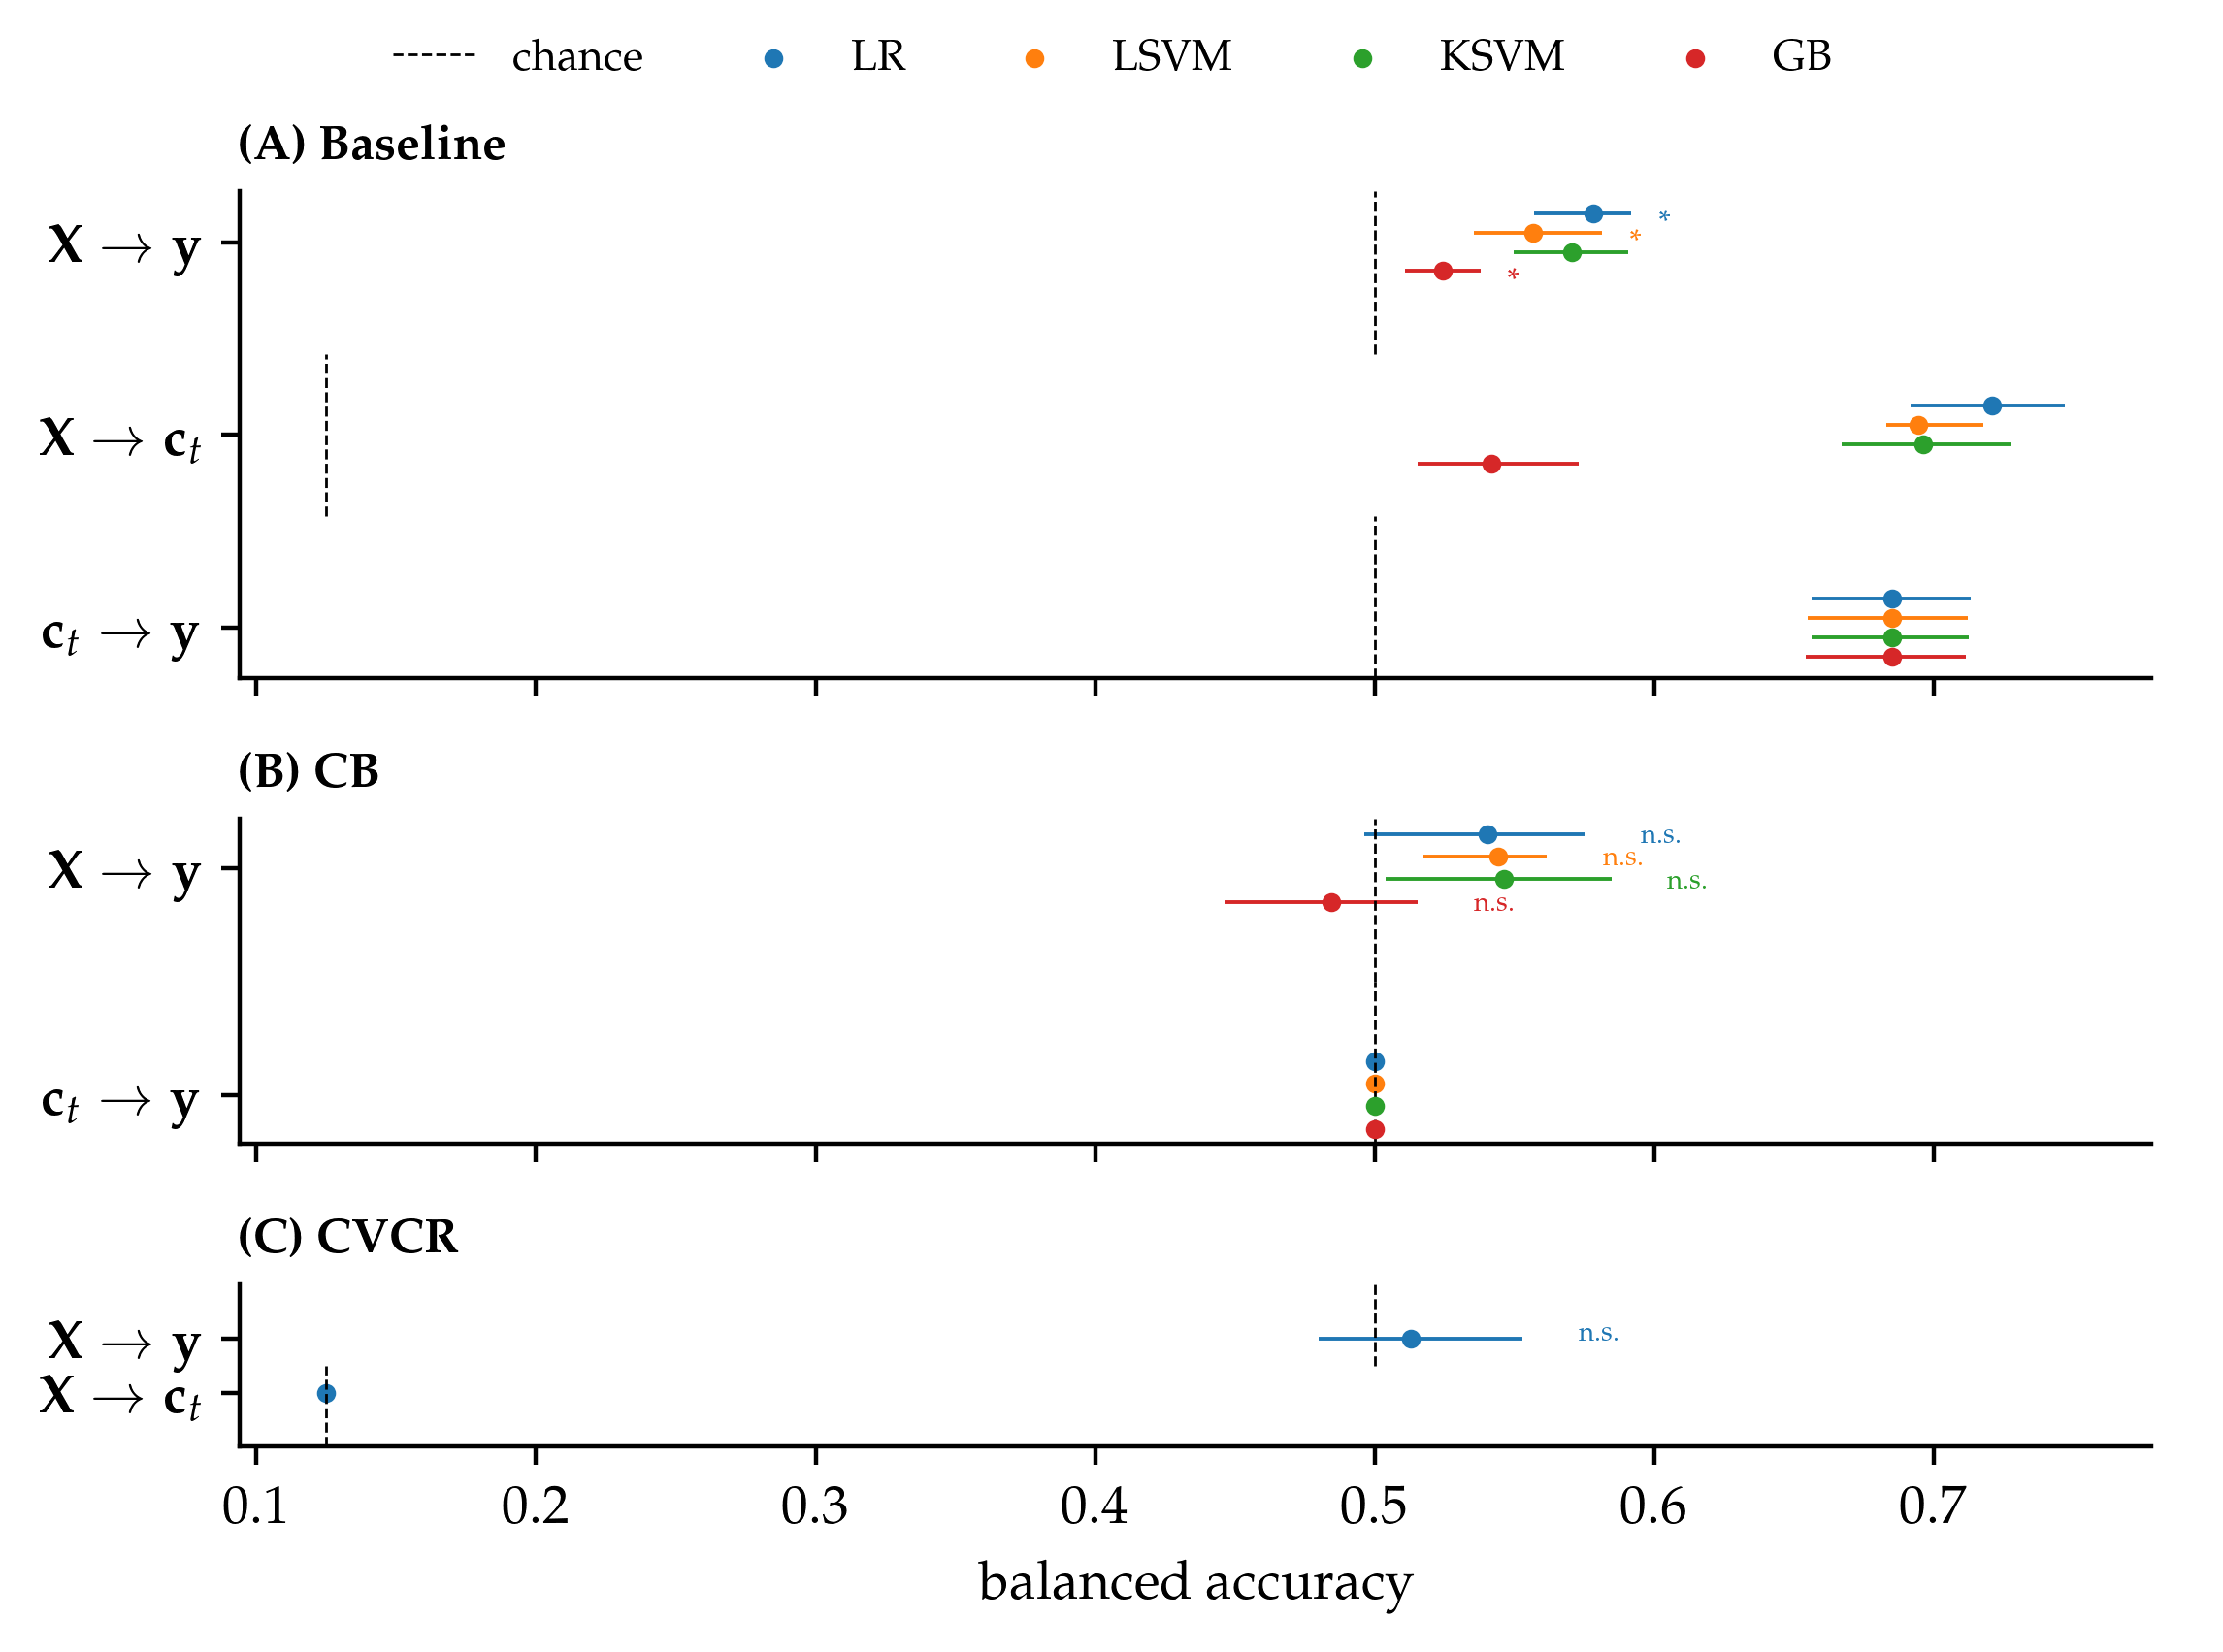

In [27]:
df = fa0
dodge = 0.3


fig, ax = plt.subplots(ncols=1, nrows=3, dpi=400, sharex=True, sharey=False, figsize=(fig_width,4.5),\
                      gridspec_kw={'height_ratios': [3, 2, 1]})


ax[0].set_title(r"\textbf{(A) Baseline}", fontsize=9, loc="left")
ax[1].set_title(r"\textbf{(B) CB}", fontsize=9, loc="left")
ax[2].set_title(r"\textbf{(C) CVCR}", fontsize=9, loc="left")
#ax[3,0].set_title(r"\textbf{(D) CB$_s$ + CVCR$_t$}", fontsize=9, loc="left")


for i, technique in enumerate(["baseline", "cb", "cvcr"]):
    setting = "id"
        
    dfx = df.query("technique == '{}' and setting == '{}'".format(technique, setting))
    dfx = dfx.query("model != 'GaussianNB'")


    if technique == "cb":
        dfx = dfx.query("io != 'X-s'").query("io != 'X-c'")
    elif technique == "cvcr":
        dfx = dfx.query("io != 's-y'").query("io != 'c-y'")
        dodge = 0


    a = sns.pointplot(y="io", x="ba-mean", hue="model", join=False, data=dfx, \
                            dodge=dodge, scale=posz, errwidth=0.85, ax=ax[i], ci=None, palette=c)

    a.legend_.remove()

    if technique == "baseline":
        ax[i].set_yticklabels([
            r"$\mathbf{X} \to \mathbf{y}$",
            r"$\mathbf{X} \to \mathbf{c}_t$",
            r"$\mathbf{c}_t \to \mathbf{y}$"
        ])
        chance = [0.5, 0.125, 0.5]
    elif technique == "cb":
        ax[i].set_yticklabels([r"$\mathbf{X} \to \mathbf{y}$", 
                               r"$\mathbf{c}_t \to \mathbf{y}$"])
        chance = [0.5, 0.5]
    elif technique == "cvcr":
        ax[i].set_yticklabels([r"$\mathbf{X} \to \mathbf{y}$", 
                               r"$\mathbf{X} \to \mathbf{c}_t$"])
        chance = [0.125, 0.5]
        dodge = 0
        ax[i].set_ylim([2, -1])

    ax[i].set_xlabel("")
    ax[i].set_ylabel("")


    n_models = len(dfx["model"].unique())
    dodge_ = np.linspace(0, dodge, n_models) - np.linspace(0, dodge, n_models).mean() 

    n_io = len(dfx.io.unique())
    if chance:
        for z, ch in enumerate(chance):
            ax[i].axvline(x=ch, ymin=z/len(chance),ymax=(z+1)/(len(chance)), label="chance", \
                            c='k', ls='--', lw=0.5)

    # Add errorbars and significance stars 
    for k, io in enumerate(dfx["io"].unique()):
        for m, model in enumerate(dfx["model"].unique()):
            if model != "LogisticRegression" and technique == "cvcr":
                continue
            dfxx = dfx.query("model == '{}' and {} == '{}'".format(model, "io", io))
            test_score = dfxx["ba-mean"].values[0]
            ci_low = dfxx["ba-ci-low"].values[0]
            ci_high = dfxx["ba-ci-high"].values[0]
            err = [[abs(test_score - ci_low)], [abs(test_score-ci_high)]]
            ax[i].errorbar(test_score, k+dodge_[m], xerr=err, c=c[m], elinewidth=lisz)
            
            pvalue = dfxx["ba-pvalue"].values[0]
            if (not np.isnan(pvalue)) and (io == 'X-y'):
                ast = return_asterisks(pvalue)
                if ast == "n.s.":
                    ax[i].text(ci_high+0.02, k+dodge_[m]+0.04, r"{}".format(ast), c=c[m], fontsize=5)
                else:
                    ax[i].text(ci_high+0.01, k+dodge_[m]+0.095, r"{}".format(ast), c=c[m], fontsize=6)



fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel("balanced accuracy")

handles, _ = ax[i].get_legend_handles_labels()
handles = [handles[i] for i in len(chance)-1 + np.arange(len(dfx["model"].unique())+1)]
fig.legend(handles, ["chance", "LR", "LSVM", "KSVM", "GB"], fontsize=8, frameon=False, loc="upper center",ncol=5)

        
fig.tight_layout()
sns.despine()

plt.subplots_adjust(top=0.9)
plt.show()

In [28]:
fa0.query("io == 'X-y'")

,Unnamed: 0,model,technique,io,ba-mean,ba_std,ba-ci-low,ba-ci-high,ba-pvalue,sens,spec,auc_ci_high,auc_ci_low,auc_mean,auc_pvalue,inmod,setting,sex
0,0,LogisticRegression,baseline,X-y,0.576250,0.040869,0.545000,0.597500,0.058941,0.592500,0.560000,0.638125,0.549000,0.594375,0.105894,dti-FA,pr,male
3,3,LogisticRegression,cb,X-y,0.474081,0.071292,0.435294,0.524265,NaN,0.465074,0.483088,0.539706,0.424265,0.473162,NaN,dti-FA,pr,male
6,6,LogisticRegression,cvcr,X-y,0.483750,0.039151,0.456250,0.505000,NaN,0.712500,0.255000,0.526000,0.438875,0.490375,NaN,dti-FA,pr,male
9,9,LinearSVC,baseline,X-y,0.537500,0.040311,0.512500,0.562500,0.107892,0.850000,0.225000,0.653750,0.567625,0.613375,0.087912,dti-FA,pr,male
12,12,LinearSVC,cb,X-y,0.481434,0.061675,0.452022,0.532537,NaN,0.318015,0.644853,0.525735,0.412132,0.466544,NaN,dti-FA,pr,male
15,15,LinearSVC,cvcr,X-y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dti-FA,pr,male
18,18,SVC,baseline,X-y,0.546250,0.047451,0.513750,0.572500,NaN,0.867500,0.225000,0.669250,0.573500,0.622125,NaN,dti-FA,pr,male
21,21,SVC,cb,X-y,0.473346,0.045403,0.440625,0.497426,NaN,0.367647,0.579044,0.505147,0.415809,0.451287,NaN,dti-FA,pr,male
24,24,SVC,cvcr,X-y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dti-FA,pr,male
27,27,GradientBoostingClassifier,baseline,X-y,0.505000,0.017854,0.497500,0.521250,0.168831,0.975000,0.035000,0.688500,0.588125,0.634750,0.050949,dti-FA,pr,male


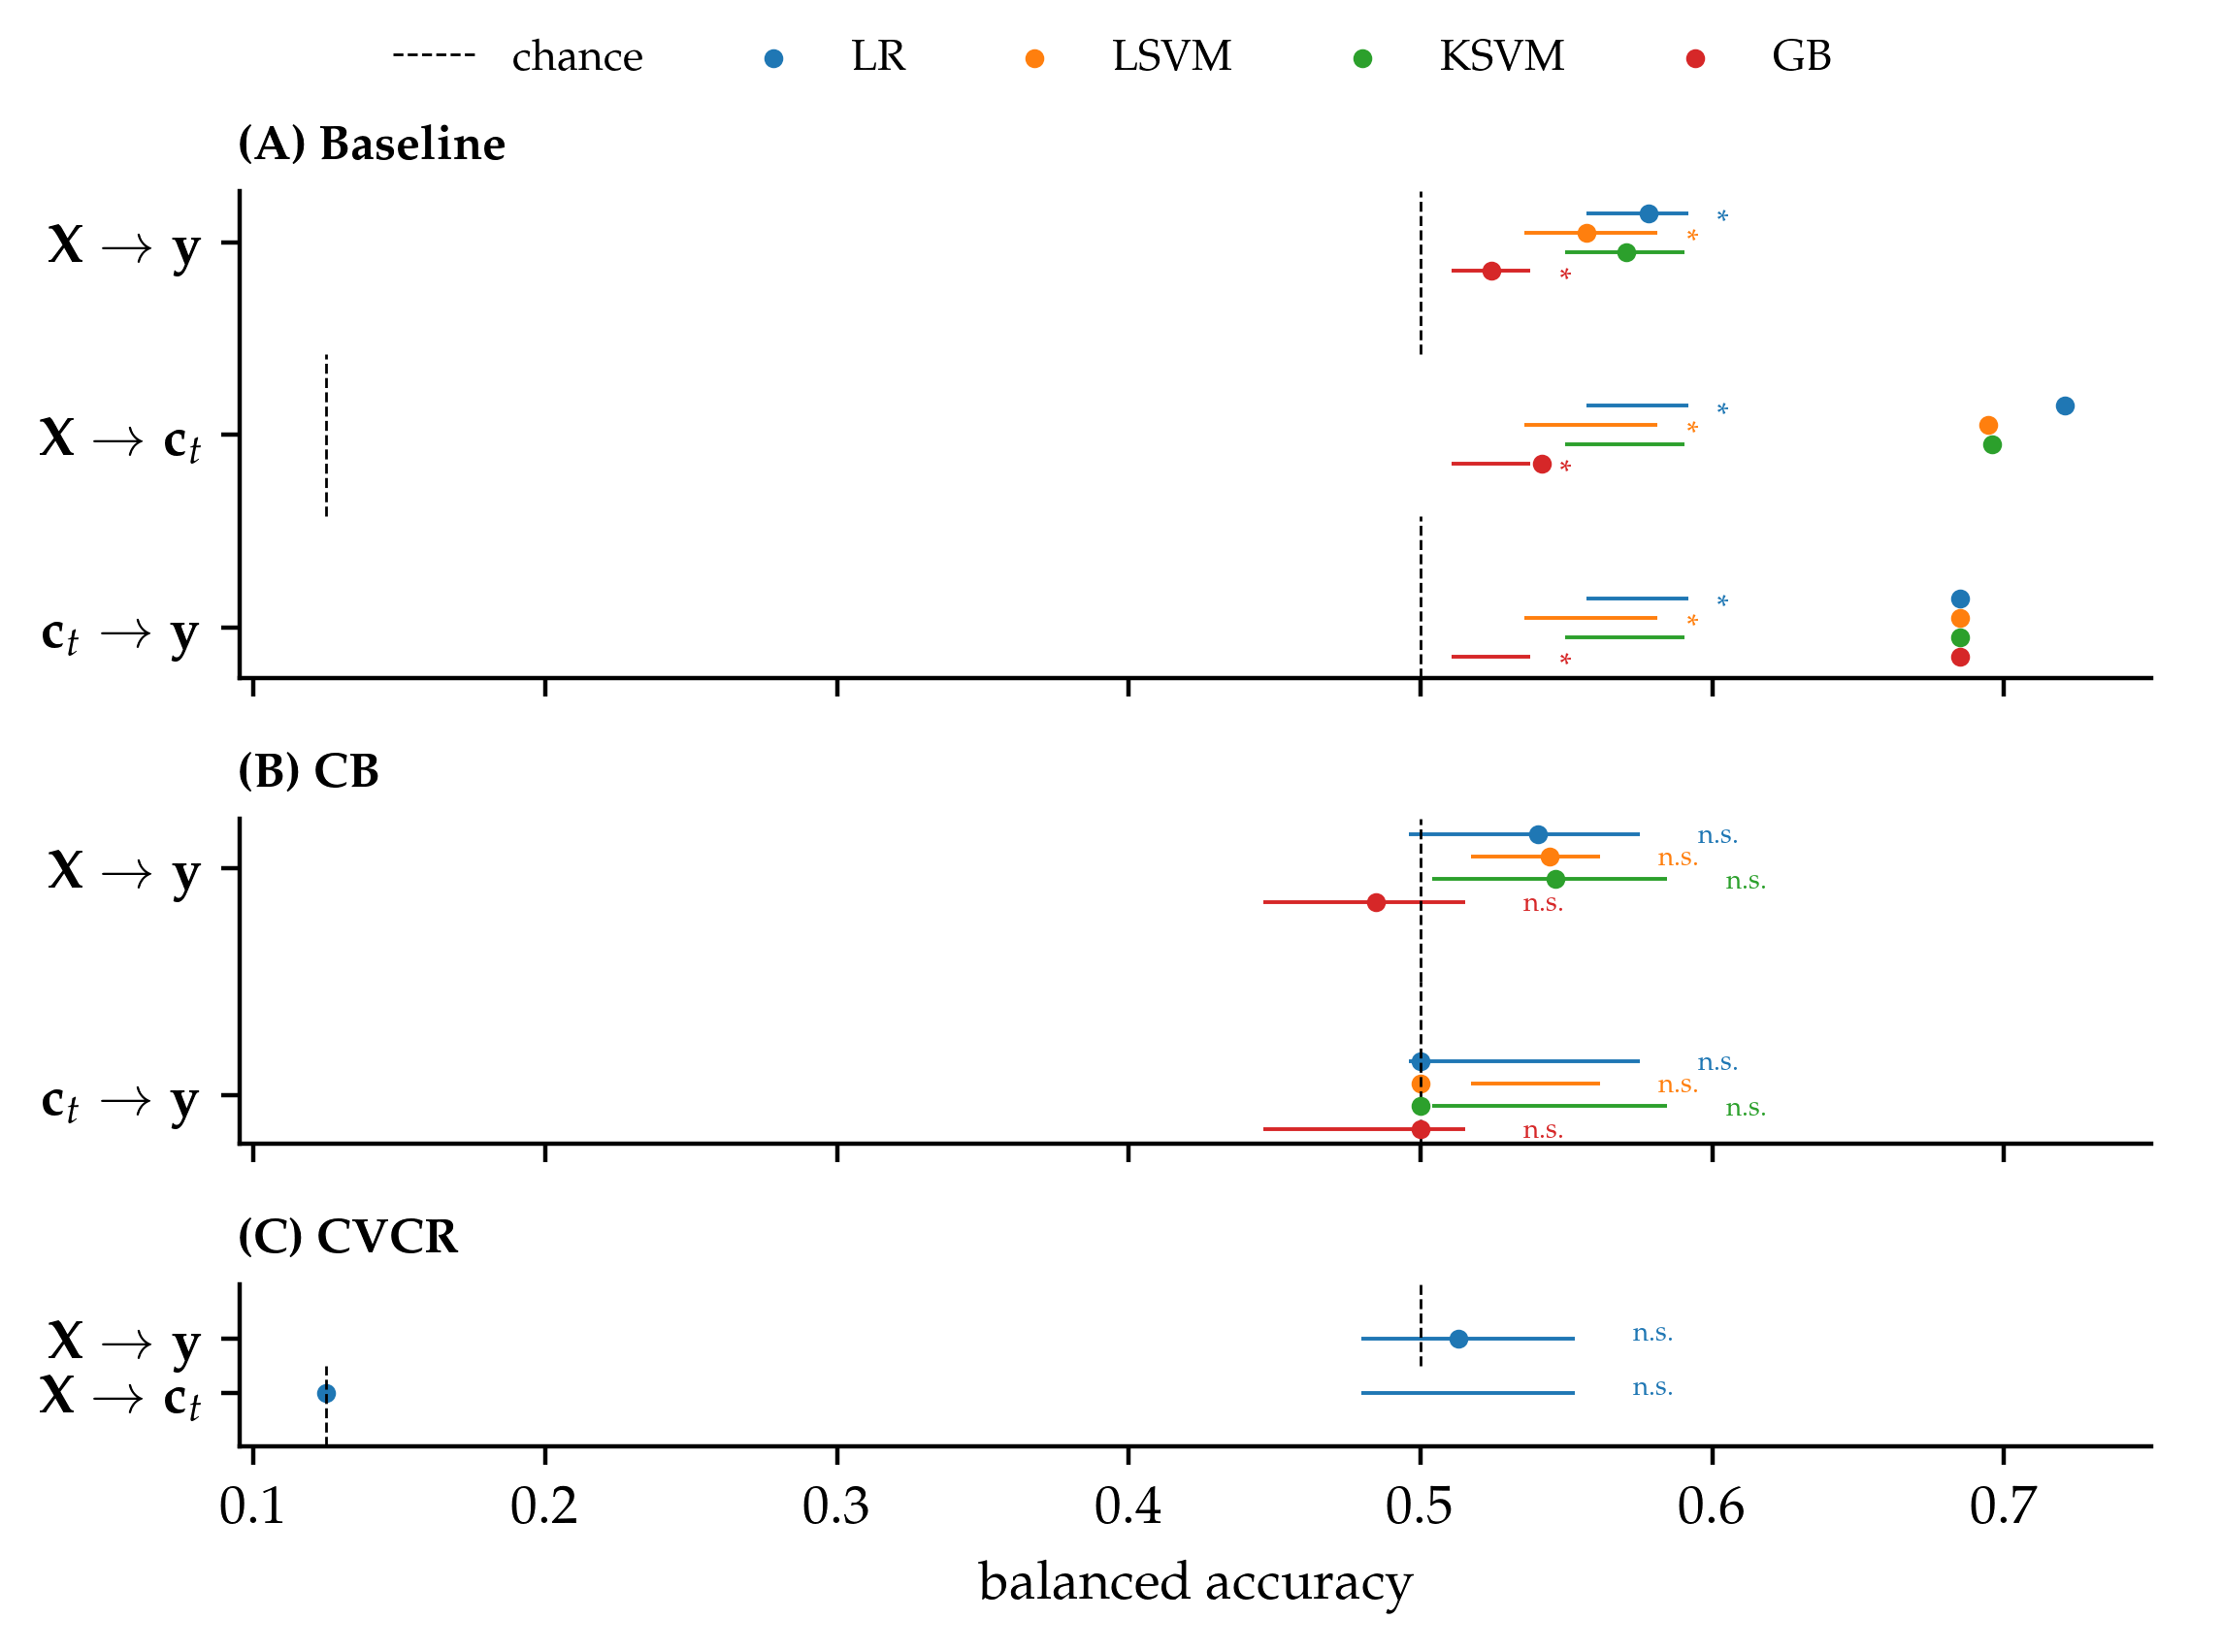

In [29]:
df = fa0
dodge = 0.3


fig, ax = plt.subplots(ncols=1, nrows=3, dpi=400, sharex=True, sharey=False, figsize=(fig_width,4.5),\
                      gridspec_kw={'height_ratios': [3, 2, 1]})


ax[0].set_title(r"\textbf{(A) Baseline}", fontsize=9, loc="left")
ax[1].set_title(r"\textbf{(B) CB}", fontsize=9, loc="left")
ax[2].set_title(r"\textbf{(C) CVCR}", fontsize=9, loc="left")
#ax[3,0].set_title(r"\textbf{(D) CB$_s$ + CVCR$_t$}", fontsize=9, loc="left")


for i, technique in enumerate(["baseline", "cb", "cvcr"]):
    setting = "id"
        
    dfx = df.query("technique == '{}' and setting == '{}'".format(technique, setting))
    dfx = dfx.query("model != 'GaussianNB'")


    if technique == "cb":
        dfx = dfx.query("io != 'X-s'").query("io != 'X-c'")
    elif technique == "cvcr":
        dfx = dfx.query("io != 's-y'").query("io != 'c-y'")
        dodge = 0


    a = sns.pointplot(y="io", x="ba-mean", hue="model", join=False, data=dfx, \
                            dodge=dodge, scale=posz, errwidth=0.85, ax=ax[i], ci=None, palette=c)

    a.legend_.remove()

    if technique == "baseline":
        ax[i].set_yticklabels([
            r"$\mathbf{X} \to \mathbf{y}$",
            r"$\mathbf{X} \to \mathbf{c}_t$",
            r"$\mathbf{c}_t \to \mathbf{y}$"
        ])
        chance = [0.5, 0.125, 0.5]
    elif technique == "cb":
        ax[i].set_yticklabels([r"$\mathbf{X} \to \mathbf{y}$", 
                               r"$\mathbf{c}_t \to \mathbf{y}$"])
        chance = [0.5, 0.5]
    elif technique == "cvcr":
        ax[i].set_yticklabels([r"$\mathbf{X} \to \mathbf{y}$", 
                               r"$\mathbf{X} \to \mathbf{c}_t$"])
        chance = [0.125, 0.5]
        dodge = 0
        ax[i].set_ylim([2, -1])

    ax[i].set_xlabel("")
    ax[i].set_ylabel("")


    n_models = len(dfx["model"].unique())
    dodge_ = np.linspace(0, dodge, n_models) - np.linspace(0, dodge, n_models).mean() 

    n_io = len(dfx.io.unique())
    if chance:
        for z, ch in enumerate(chance):
            ax[i].axvline(x=ch, ymin=z/len(chance),ymax=(z+1)/(len(chance)), label="chance", \
                            c='k', ls='--', lw=0.5)

    # Add errorbars and significance stars 
    for k, io in enumerate(dfx["io"].unique()):
        io = "X-y"
        for m, model in enumerate(dfx["model"].unique()):
            if model != "LogisticRegression" and technique == "cvcr":
                continue
            dfxx = dfx.query("model == '{}' and {} == '{}'".format(model, "io", io))
            test_score = dfxx["ba-mean"].values[0]
            ci_low = dfxx["ba-ci-low"].values[0]
            ci_high = dfxx["ba-ci-high"].values[0]
            err = [[abs(test_score - ci_low)], [abs(test_score-ci_high)]]
            ax[i].errorbar(test_score, k+dodge_[m], xerr=err, c=c[m], elinewidth=lisz)
            
            pvalue = dfxx["ba-pvalue"].values[0]
            if (not np.isnan(pvalue)) and (io == 'X-y'):
                ast = return_asterisks(pvalue)
                if ast == "n.s.":
                    ax[i].text(ci_high+0.02, k+dodge_[m]+0.04, r"{}".format(ast), c=c[m], fontsize=5)
                else:
                    ax[i].text(ci_high+0.01, k+dodge_[m]+0.095, r"{}".format(ast), c=c[m], fontsize=6)



fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
plt.xlabel("balanced accuracy")

handles, _ = ax[i].get_legend_handles_labels()
handles = [handles[i] for i in len(chance)-1 + np.arange(len(dfx["model"].unique())+1)]
fig.legend(handles, ["chance", "LR", "LSVM", "KSVM", "GB"], fontsize=8, frameon=False, loc="upper center",ncol=5)

        
fig.tight_layout()
sns.despine()

plt.subplots_adjust(top=0.9)
plt.show()

In [30]:
from statsmodels.stats.multitest import fdrcorrection

In [31]:
fdrcorrection([0.003, 0.06, 0.02, 0.01, 0.001], alpha=0.05, is_sorted=False)

(array([ True, False,  True,  True,  True]),
 array([0.0075    , 0.06      , 0.025     , 0.01666667, 0.005     ]))